### Importation des librairies

In [ ]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib as mpl
mpl.rcParams["figure.figsize"] = (9, 6)
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!ls drive/MyDrive/

 5518124b75d6c6dfee4c2e4c0cfa716a.jpg
 9ff54c12cc7ffd7c1a6724477b8fea2f.jpg
 application_test.csv
 application_train.csv
 Attestation.pdf
 bureau_balance.csv
 bureau.csv
'Colab Notebooks'
 credit_card_balance.csv
'Diplôme (1).pdf'
'Diplôme (2).pdf'
 Diplôme.pdf
'Dossiers Administratif s'
'Dossier sans titre'
 feat_importance.csv
 fichier.csv
 fichierdata.csv
'Formulaire sans titre.gform'
 HomeCredit_columns_description.csv
 Images
 installments_payments.csv
 POS_CASH_balance.csv
 previous_application.csv
 Recip.TS.pdf
 sample_submission.csv
 TCHACOULA_Saliou_1_new_notebook_pretraitement_feature_extraction_faisaibilite_112023.ipynb
 TCHACOULA_Saliou_2_dossier_code_122023.ipynb


In [ ]:
application_train = pd.read_csv("./drive/MyDrive/application_train.csv")
application_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

In [ ]:
application_train.isna().mean()

SK_ID_CURR                    0.000000
TARGET                        0.000000
NAME_CONTRACT_TYPE            0.000000
CODE_GENDER                   0.000000
FLAG_OWN_CAR                  0.000000
                                ...   
AMT_REQ_CREDIT_BUREAU_DAY     0.135016
AMT_REQ_CREDIT_BUREAU_WEEK    0.135016
AMT_REQ_CREDIT_BUREAU_MON     0.135016
AMT_REQ_CREDIT_BUREAU_QRT     0.135016
AMT_REQ_CREDIT_BUREAU_YEAR    0.135016
Length: 122, dtype: float64

In [ ]:
application_train.shape

(307511, 122)

In [ ]:
application_test = pd.read_csv("./drive/MyDrive/application_test.csv")
application_test.head()

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0  
1                        0.0                         3.0  
2                        1.0                         4.0  
3                        0.0                         3.0  
4                        NaN                         NaN  

[5 rows x 121 columns]

In [ ]:
application_test.shape

(48744, 121)

In [ ]:
bureau = pd.read_csv("./drive/MyDrive/bureau.csv")
bureau.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

In [ ]:
bureau.shape

(1716428, 17)

In [ ]:
bureau_balance = pd.read_csv("./drive/MyDrive/bureau_balance.csv")
bureau_balance.head()

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

In [ ]:
bureau_balance.shape

(27299925, 3)

In [ ]:
credit_card_balance = pd.read_csv("./drive/MyDrive/credit_card_balance.csv")
credit_card_balance.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  ...  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                 1700.325  ...          0.000                 0.000   
1                 2250.000  ...      64875.555             64875.555   
2                 2250.000  ...      31460.085             31460.085   
3                11795.760  ...     233048.970            233048.970   
4                22924.890  ...     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM  NAME_CONTRACT_STATUS  \
0                       1.0                       35.0                Active   
1                       0.0                       69.0                Active   
2                       0.0                       30.0                Active   
3                       0.0                       10.0                Active   
4                       1.0                      101.0                Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0  

[5 rows x 23 columns]

In [ ]:
credit_card_balance.shape

(3840312, 23)

In [ ]:
HomeCredit_columns_description = pd.read_csv("./drive/MyDrive/HomeCredit_columns_description.csv", encoding="latin1")
HomeCredit_columns_description.head()

Unnamed: 0                         Table                 Row  \
0           1  application_{train|test}.csv          SK_ID_CURR   
1           2  application_{train|test}.csv              TARGET   
2           5  application_{train|test}.csv  NAME_CONTRACT_TYPE   
3           6  application_{train|test}.csv         CODE_GENDER   
4           7  application_{train|test}.csv        FLAG_OWN_CAR   

                                         Description Special  
0                           ID of loan in our sample     NaN  
1  Target variable (1 - client with payment diffi...     NaN  
2        Identification if loan is cash or revolving     NaN  
3                               Gender of the client     NaN  
4                      Flag if the client owns a car     NaN

In [ ]:
HomeCredit_columns_description.groupby("Table")[["Row", "Description"]].count()

Row  Description
Table                                         
POS_CASH_balance.csv            8            8
application_{train|test}.csv  122          122
bureau.csv                     17           17
bureau_balance.csv              3            3
credit_card_balance.csv        23           23
installments_payments.csv       8            8
previous_application.csv       38           38

In [ ]:
installments_payments = pd.read_csv("./drive/MyDrive/installments_payments.csv")
installments_payments.head()

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

In [ ]:
installments_payments.shape

(13605401, 8)

In [ ]:
POS_CASH_balance = pd.read_csv("./drive/MyDrive/POS_CASH_balance.csv")
POS_CASH_balance.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

In [ ]:
POS_CASH_balance.shape

(10001358, 8)

In [ ]:
previous_application = pd.read_csv("./drive/MyDrive/previous_application.csv")
previous_application.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START  ... NAME_SELLER_INDUSTRY  CNT_PAYMENT  \
0                       15  ...         Connectivity         12.0   
1                       11  ...                  XNA         36.0   
2                       11  ...                  XNA         12.0   
3                        7  ...                  XNA         12.0   
4                        9  ...                  XNA         24.0   

   NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0            middle  POS mobile with interest            365243.0   
1        low_action          Cash X-Sell: low            365243.0   
2              high         Cash X-Sell: high            365243.0   
3            middle       Cash X-Sell: middle            365243.0   
4              high         Cash Street: high                 NaN   

  DAYS_FIRST_DUE DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE DAYS_TERMINATION  \
0          -42.0                     300.0          -42.0            -37.0   
1         -134.0                     916.0       365243.0         365243.0   
2         -271.0                      59.0       365243.0         365243.0   
3         -482.0                    -152.0         -182.0           -177.0   
4            NaN                       NaN            NaN              NaN   

  NFLAG_INSURED_ON_APPROVAL  
0                       0.0  
1                       1.0  
2                       1.0  
3                       1.0  
4                       NaN  

[5 rows x 37 columns]

In [ ]:
previous_application.shape

(1670214, 37)

In [ ]:
sample_submission = pd.read_csv("./drive/MyDrive/sample_submission.csv")
sample_submission.head()

SK_ID_CURR  TARGET
0      100001     0.5
1      100005     0.5
2      100013     0.5
3      100028     0.5
4      100038     0.5

In [ ]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [ ]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('./drive/MyDrive/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('./drive/MyDrive/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

In [ ]:
application_train_test(num_rows=307511, nan_as_category=False)

Train samples: 307511, test samples: 48744


index  SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0           0      100002     1.0            0             0                0   
1           1      100003     0.0            1             0                1   
2           2      100004     0.0            0             1                0   
3           3      100006     0.0            1             0                0   
4           4      100007     0.0            0             0                0   
...       ...         ...     ...          ...           ...              ...   
356250  48739      456221     NaN            1             0                0   
356251  48740      456222     NaN            1             0                1   
356252  48741      456223     NaN            1             1                0   
356253  48742      456224     NaN            0             0                1   
356254  48743      456250     NaN            1             1                1   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  ...  \
0                  0          202500.0    406597.5      24700.5  ...   
1                  0          270000.0   1293502.5      35698.5  ...   
2                  0           67500.0    135000.0       6750.0  ...   
3                  0          135000.0    312682.5      29686.5  ...   
4                  0          121500.0    513000.0      21865.5  ...   
...              ...               ...         ...          ...  ...   
356250             0          121500.0    412560.0      17473.5  ...   
356251             2          157500.0    622413.0      31909.5  ...   
356252             1          202500.0    315000.0      33205.5  ...   
356253             0          225000.0    450000.0      25128.0  ...   
356254             0          135000.0    312768.0      24709.5  ...   

        WALLSMATERIAL_MODE_Panel  WALLSMATERIAL_MODE_Stone, brick  \
0                              0                                1   
1                              0                                0   
2                              0                                0   
3                              0                                0   
4                              0                                0   
...                          ...                              ...   
356250                         0                                0   
356251                         0                                0   
356252                         0                                1   
356253                         1                                0   
356254                         0                                0   

        WALLSMATERIAL_MODE_Wooden  EMERGENCYSTATE_MODE_No  \
0                               0                       1   
1                               0                       1   
2                               0                       0   
3                               0                       0   
4                               0                       0   
...                           ...                     ...   
356250                          0                       0   
356251                          0                       0   
356252                          0                       1   
356253                          0                       1   
356254                          0                       0   

        EMERGENCYSTATE_MODE_Yes  DAYS_EMPLOYED_PERC  INCOME_CREDIT_PERC  \
0                             0            0.067329            0.498036   
1                             0            0.070862            0.208736   
2                             0            0.011814            0.500000   
3                             0            0.159905            0.431748   
4                             0            0.152418            0.236842   
...                         ...                 ...                 ...   
356250                        0            0.258838            0.294503   
356251  

In [ ]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('./drive/MyDrive/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('./drive/MyDrive/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']

    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [ ]:
bureau_and_balance(num_rows=27299925, nan_as_category=False)

BURO_DAYS_CREDIT_MIN  BURO_DAYS_CREDIT_MAX  BURO_DAYS_CREDIT_MEAN  \
SK_ID_CURR                                                                      
100001                     -1572                   -49            -735.000000   
100002                     -1437                  -103            -874.000000   
100003                     -2586                  -606           -1400.750000   
100004                     -1326                  -408            -867.000000   
100005                      -373                   -62            -190.666667   
...                          ...                   ...                    ...   
456249                     -2713                  -483           -1667.076923   
456250                     -1002                  -760            -862.000000   
456253                      -919                  -713            -867.500000   
456254                     -1104                 -1104           -1104.000000   
456255                     -2337                  -363           -1089.454545   

            BURO_DAYS_CREDIT_VAR  BURO_DAYS_CREDIT_ENDDATE_MIN  \
SK_ID_CURR                                                       
100001             240043.666667                       -1329.0   
100002             186150.000000                       -1072.0   
100003             827783.583333                       -2434.0   
100004             421362.000000                        -595.0   
100005              26340.333333                        -128.0   
...                          ...                           ...   
456249             407302.243590                       -2499.0   
456250              15724.000000                        -272.0   
456253              10609.000000                        -189.0   
456254                       NaN                        -859.0   
456255             502786.672727                       -1243.0   

            BURO_DAYS_CREDIT_ENDDATE_MAX  BURO_DAYS_CREDIT_ENDDATE_MEAN  \
SK_ID_CURR                                                                
100001                            1778.0                      82.428571   
100002                             780.0                    -349.000000   
100003                            1216.0                    -544.500000   
100004                            -382.0                    -488.500000   
100005                            1324.0                     439.333333   
...                                  ...                            ...   
456249                            1363.0                   -1232.333333   
456250                            2340.0                    1288.333333   
456253                            1113.0                     280.500000   
456254                            -859.0                    -859.000000   
456255                           27320.0                    3231.272727   

            BURO_DAYS_CREDIT_UPDATE_MEAN  BURO_CREDIT_DAY_OVERDUE_MAX  \
SK_ID_CURR                                                              
100001                        -93.142857                            0   
100002                       -499.875000                            0   
100003                       -816.000000                            0   
100004                       -532.000000                            0   
100005                        -54.333333                            0   
...                                  ...                          ...   
456249                      -1064.538462                            0   
456250                        -60.333333                            0   
456253                       -253.250000                            0   
456254                       -401.000000                            0   
456255                       -531.090909                            0   

            BURO_CREDIT_DAY_OVERDUE_MEAN  ...  \
SK_ID_CURR                                ...   
100001                               0.0  ...   
100002                    

In [ ]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('./drive/MyDrive/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [ ]:
previous_applications(num_rows=1670214, nan_as_category=False)

PREV_AMT_ANNUITY_MIN  PREV_AMT_ANNUITY_MAX  PREV_AMT_ANNUITY_MEAN  \
SK_ID_CURR                                                                      
100001                  3951.000              3951.000            3951.000000   
100002                  9251.775              9251.775            9251.775000   
100003                  6737.310             98356.995           56553.990000   
100004                  5357.250              5357.250            5357.250000   
100005                  4813.200              4813.200            4813.200000   
...                          ...                   ...                    ...   
456251                  6605.910              6605.910            6605.910000   
456252                 10074.465             10074.465           10074.465000   
456253                  3973.095              5567.715            4770.405000   
456254                  2296.440             19065.825           10681.132500   
456255                  2250.000             54022.140           20775.391875   

            PREV_AMT_APPLICATION_MIN  PREV_AMT_APPLICATION_MAX  \
SK_ID_CURR                                                       
100001                       24835.5                   24835.5   
100002                      179055.0                  179055.0   
100003                       68809.5                  900000.0   
100004                       24282.0                   24282.0   
100005                           0.0                   44617.5   
...                              ...                       ...   
456251                       40455.0                   40455.0   
456252                       57595.5                   57595.5   
456253                       19413.0                   28912.5   
456254                       18846.0                  223789.5   
456255                       45000.0                 1170000.0   

            PREV_AMT_APPLICATION_MEAN  PREV_AMT_CREDIT_MIN  \
SK_ID_CURR                                                   
100001                      24835.500              23787.0   
100002                     179055.000             179055.0   
100003                     435436.500              68053.5   
100004                      24282.000              20106.0   
100005                      22308.750                  0.0   
...                               ...                  ...   
456251                      40455.000              40455.0   
456252                      57595.500              56821.5   
456253                      24162.750              13945.5   
456254                     121317.750              21456.0   
456255                     362770.875              45000.0   

            PREV_AMT_CREDIT_MAX  PREV_AMT_CREDIT_MEAN  \
SK_ID_CURR                                              
100001                  23787.0              23787.00   
100002                 179055.0             179055.00   
100003                1035882.0             484191.00   
100004                  20106.0              20106.00   
100005                  40153.5              20076.75   
...                         ...                   ...   
456251                  40455.0              40455.00   
456252                  56821.5              56821.50   
456253                  27306.0              20625.75   
456254                 247423.5             134439.75   
456255                1271929.5             424431.00   

            PREV_APP_CREDIT_PERC_MIN  ...  \
SK_ID_CURR                            ...   
100001                      1.044079  ...   
100002                      1.000000  ...   
100003                      0.868825  ...   
100004                      1.207699  ...   
100005                      1.111173  ...   
...                              ...  ...   
456251                      1.000000  ...   
456252                      1.013622  ...   
456253                      1.058833  ...   
456254                      0.878356  ...   
456255    

In [ ]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('./drive/MyDrive/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [ ]:
pos_cash(num_rows=10001358, nan_as_category=False)

POS_MONTHS_BALANCE_MAX  POS_MONTHS_BALANCE_MEAN  \
SK_ID_CURR                                                    
100001                         -53               -72.555556   
100002                          -1               -10.000000   
100003                         -18               -43.785714   
100004                         -24               -25.500000   
100005                         -15               -20.000000   
...                            ...                      ...   
456251                          -1                -5.000000   
456252                         -76               -79.000000   
456253                         -57               -79.235294   
456254                          -1                -5.550000   
456255                          -2               -16.408451   

            POS_MONTHS_BALANCE_SIZE  POS_SK_DPD_MAX  POS_SK_DPD_MEAN  \
SK_ID_CURR                                                             
100001                            9               7         0.777778   
100002                           19               0         0.000000   
100003                           28               0         0.000000   
100004                            4               0         0.000000   
100005                           11               0         0.000000   
...                             ...             ...              ...   
456251                            9               0         0.000000   
456252                            7               0         0.000000   
456253                           17               5         0.294118   
456254                           20               0         0.000000   
456255                           71               5         0.070423   

            POS_SK_DPD_DEF_MAX  POS_SK_DPD_DEF_MEAN  \
SK_ID_CURR                                            
100001                       7             0.777778   
100002                       0             0.000000   
100003                       0             0.000000   
100004                       0             0.000000   
100005                       0             0.000000   
...                        ...                  ...   
456251                       0             0.000000   
456252                       0             0.000000   
456253                       5             0.294118   
456254                       0             0.000000   
456255                       5             0.070423   

            POS_NAME_CONTRACT_STATUS_Active_MEAN  \
SK_ID_CURR                                         
100001                                  0.777778   
100002                                  1.000000   
100003                                  0.928571   
100004                                  0.750000   
100005                                  0.818182   
...                                          ...   
456251                                  0.777778   
456252                                  0.857143   
456253                                  0.882353   
456254                                  1.000000   
456255                                  0.915493   

            POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN  \
SK_ID_CURR                                                 
100001                                               0.0   
100002                                               0.0   
100003                                               0.0   
100004                                               0.0   
100005                                               0.0   
...                                                  ...   
456251                                               0.0   
456252                                               0.0   
456253                                               0.0   
456254                                               0.0   
456255                                               0.0   

            POS_NAME_CONTRACT_STATUS_Approved_MEAN  \
SK_ID_CURR                 

In [ ]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('./drive/MyDrive/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [ ]:
installments_payments(num_rows=13605401, nan_as_category=False)

INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE  INSTAL_DPD_MAX  \
SK_ID_CURR                                                          
100001                                          2            11.0   
100002                                          2             0.0   
100003                                          2             0.0   
100004                                          2             0.0   
100005                                          2             1.0   
...                                           ...             ...   
456251                                          2             0.0   
456252                                          1             3.0   
456253                                          1             9.0   
456254                                          1             0.0   
456255                                          4             7.0   

            INSTAL_DPD_MEAN  INSTAL_DPD_SUM  INSTAL_DBD_MAX  INSTAL_DBD_MEAN  \
SK_ID_CURR                                                                     
100001             1.571429            11.0            36.0         8.857143   
100002             0.000000             0.0            31.0        20.421053   
100003             0.000000             0.0            14.0         7.160000   
100004             0.000000             0.0            11.0         7.666667   
100005             0.111111             1.0            37.0        23.666667   
...                     ...             ...             ...              ...   
456251             0.000000             0.0            46.0        36.285714   
456252             0.500000             3.0            11.0         3.333333   
456253             0.642857             9.0            51.0        15.142857   
456254             0.000000             0.0            31.0        19.000000   
456255             0.702703            52.0            35.0         8.770270   

            INSTAL_DBD_SUM  INSTAL_PAYMENT_PERC_MAX  INSTAL_PAYMENT_PERC_MEAN  \
SK_ID_CURR                                                                      
100001                62.0                  1.00000                  1.000000   
100002               388.0                  1.00000                  1.000000   
100003               179.0                  1.00000                  1.000000   
100004                23.0                  1.00000                  1.000000   
100005               213.0                  1.00000                  1.000000   
...                    ...                      ...                       ...   
456251               254.0                  1.00000                  1.000000   
456252                20.0                  1.00000                  1.000000   
456253               212.0                  1.00000                  0.928571   
456254               361.0                  1.00000                  1.000000   
456255               649.0                 12.38847                  1.033463   

            INSTAL_PAYMENT_PERC_SUM  ...  INSTAL_AMT_INSTALMENT_MEAN  \
SK_ID_CURR                           ...                               
100001                     7.000000  ...                 5885.132143   
100002                    19.000000  ...                11559.247105   
100003                    25.000000  ...                64754.586000   
100004                     3.000000  ...                 7096.155000   
100005                     9.000000  ...                 6240.205000   
...                             ...  ...                         ...   
456251                     7.000000  ...                 7492.924286   
456252                     6.000000  ...                10069.867500   
456253                    13.000000  ...                 4399.707857   
456254                    19.000000  ...                10239.832895   
456255                    76.476278  ...                41464.713649   

            INSTAL_AMT_INSTALMENT_SUM  INSTAL_AMT_PAYMENT_MIN  \
SK_ID_CURR       

In [ ]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('./drive/MyDrive/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [ ]:
credit_card_balance(num_rows=3840312, nan_as_category=False)

CC_MONTHS_BALANCE_MIN  CC_MONTHS_BALANCE_MAX  \
SK_ID_CURR                                                 
100006                         -6                     -1   
100011                        -75                     -2   
100013                        -96                     -1   
100021                        -18                     -2   
100023                        -11                     -4   
...                           ...                    ...   
456244                        -41                     -1   
456246                         -9                     -2   
456247                        -96                     -2   
456248                        -24                     -2   
456250                        -12                     -1   

            CC_MONTHS_BALANCE_MEAN  CC_MONTHS_BALANCE_SUM  \
SK_ID_CURR                                                  
100006                        -3.5                    -21   
100011                       -38.5                  -2849   
100013                       -48.5                  -4656   
100021                       -10.0                   -170   
100023                        -7.5                    -60   
...                            ...                    ...   
456244                       -21.0                   -861   
456246                        -5.5                    -44   
456247                       -49.0                  -4655   
456248                       -13.0                   -299   
456250                        -6.5                    -78   

            CC_MONTHS_BALANCE_VAR  CC_AMT_BALANCE_MIN  CC_AMT_BALANCE_MAX  \
SK_ID_CURR                                                                  
100006                        3.5               0.000               0.000   
100011                      462.5               0.000          189000.000   
100013                      776.0               0.000          161420.220   
100021                       25.5               0.000               0.000   
100023                        6.0               0.000               0.000   
...                           ...                 ...                 ...   
456244                      143.5               0.000          453627.675   
456246                        6.0               0.000           43490.115   
456247                      760.0               0.000          190202.130   
456248                       46.0               0.000               0.000   
456250                       13.0          153832.725          200208.915   

            CC_AMT_BALANCE_MEAN  CC_AMT_BALANCE_SUM  CC_AMT_BALANCE_VAR  ...  \
SK_ID_CURR                                                               ...   
100006                 0.000000               0.000        0.000000e+00  ...   
100011             54482.111149         4031676.225        4.641321e+09  ...   
100013             18159.919219         1743352.245        1.869473e+09  ...   
100021                 0.000000               0.000        0.000000e+00  ...   
100023                 0.000000               0.000        0.000000e+00  ...   
...                         ...                 ...                 ...  ...   
456244            131834.730732         5405223.960        3.295703e+10  ...   
456246             13136.731875          105093.855        3.335511e+08  ...   
456247             23216.396211         2205557.640        3.200871e+09  ...   
456248                 0.000000               0.000        0.000000e+00  ...   
456250            173589.326250         2083071.915        1.667716e+08  ...   

            CC_NAME_CONTRACT_STATUS_Signed_MAX  \
SK_ID_CURR                                       
100006                                       0   
100011                                       0   
100013                                       0   
100021                                       0   
100023                                       0   
...                                        .

In [ ]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('./drive/MyDrive/application_train.csv', nrows= int(len(application_train)/4))
    test_df = pd.read_csv('./drive/MyDrive/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('./drive/MyDrive/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('./drive/MyDrive/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']

    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('./drive/MyDrive/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('./drive/MyDrive/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('./drive/MyDrive/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('./drive/MyDrive/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [ ]:
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    print(feats)

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1)

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
            eval_metric= 'auc')

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

    # Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

In [ ]:
import re

Train samples: 76877, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 26s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 17s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 10s
Installments payments df shape: (339587, 26)
Process installments payments - done in 25s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 13s
Starting LightGBM. Train shape: (76875, 798), test shape: (48744, 798)
['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_N

<ipython-input-6-f8a8f2945f52>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['TARGET'] = sub_preds


Run LightGBM with kfold - done in 13673s
Full model run - done in 13767s


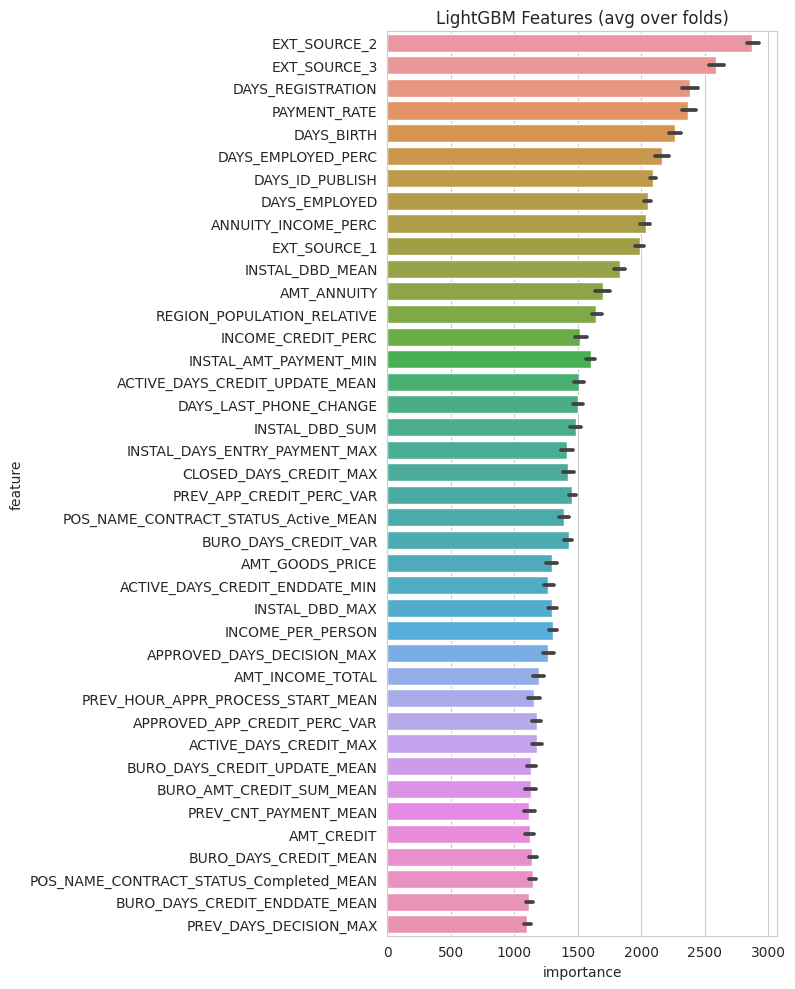

In [ ]:
def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows=num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    with timer("Run LightGBM with kfold"):
        df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)
    return df, feat_importance

if __name__ == "__main__":
    submission_file_name = "submission_kernel02.csv"
    with timer("Full model run"):
        df, feat_importance = main()


In [ ]:
df.head()

index  SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      0      100002     1.0            0             0                0   
1      1      100003     0.0            1             0                1   
2      2      100004     0.0            0             1                0   
3      3      100006     0.0            1             0                0   
4      4      100007     0.0            0             0                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  ...  \
0             0          202500.0    406597.5      24700.5  ...   
1             0          270000.0   1293502.5      35698.5  ...   
2             0           67500.0    135000.0       6750.0  ...   
3             0          135000.0    312682.5      29686.5  ...   
4             0          121500.0    513000.0      21865.5  ...   

   CC_NAME_CONTRACT_STATUS_Signed_MAX  CC_NAME_CONTRACT_STATUS_Signed_MEAN  \
0                                 NaN                                  NaN   
1                                 NaN                                  NaN   
2                                 NaN                                  NaN   
3                                 0.0                                  0.0   
4                                 NaN                                  NaN   

   CC_NAME_CONTRACT_STATUS_Signed_SUM  CC_NAME_CONTRACT_STATUS_Signed_VAR  \
0                                 NaN                                 NaN   
1                                 NaN                                 NaN   
2                                 NaN                                 NaN   
3                                 0.0                                 0.0   
4                                 NaN                                 NaN   

   CC_NAME_CONTRACT_STATUS_nan_MIN  CC_NAME_CONTRACT_STATUS_nan_MAX  \
0                              NaN                              NaN   
1                              NaN                              NaN   
2                              NaN                              NaN   
3                              0.0                              0.0   
4                              NaN                              NaN   

   CC_NAME_CONTRACT_STATUS_nan_MEAN  CC_NAME_CONTRACT_STATUS_nan_SUM  \
0                               NaN                              NaN   
1                               NaN                              NaN   
2                               NaN                              NaN   
3                               0.0                              0.0   
4                               NaN                              NaN   

   CC_NAME_CONTRACT_STATUS_nan_VAR  CC_COUNT  
0                              NaN       NaN  
1                              NaN       NaN  
2                              NaN       NaN  
3                              0.0       6.0  
4                              NaN       NaN  

[5 rows x 798 columns]

In [ ]:
df.columns

Index(['index', 'SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY',
       ...
       'CC_NAME_CONTRACT_STATUS_Signed_MAX',
       'CC_NAME_CONTRACT_STATUS_Signed_MEAN',
       'CC_NAME_CONTRACT_STATUS_Signed_SUM',
       'CC_NAME_CONTRACT_STATUS_Signed_VAR', 'CC_NAME_CONTRACT_STATUS_nan_MIN',
       'CC_NAME_CONTRACT_STATUS_nan_MAX', 'CC_NAME_CONTRACT_STATUS_nan_MEAN',
       'CC_NAME_CONTRACT_STATUS_nan_SUM', 'CC_NAME_CONTRACT_STATUS_nan_VAR',
       'CC_COUNT'],
      dtype='object', length=798)

In [ ]:
df = pd.read_csv("./drive/MyDrive/fichierdata.csv")
df.head()

index  SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      0      100002     1.0            0             0                0   
1      1      100003     0.0            1             0                1   
2      2      100004     0.0            0             1                0   
3      3      100006     0.0            1             0                0   
4      4      100007     0.0            0             0                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  ...  \
0             0          202500.0    406597.5      24700.5  ...   
1             0          270000.0   1293502.5      35698.5  ...   
2             0           67500.0    135000.0       6750.0  ...   
3             0          135000.0    312682.5      29686.5  ...   
4             0          121500.0    513000.0      21865.5  ...   

   CC_NAME_CONTRACT_STATUS_Signed_MAX  CC_NAME_CONTRACT_STATUS_Signed_MEAN  \
0                                 NaN                                  NaN   
1                                 NaN                                  NaN   
2                                 NaN                                  NaN   
3                                 0.0                                  0.0   
4                                 NaN                                  NaN   

   CC_NAME_CONTRACT_STATUS_Signed_SUM  CC_NAME_CONTRACT_STATUS_Signed_VAR  \
0                                 NaN                                 NaN   
1                                 NaN                                 NaN   
2                                 NaN                                 NaN   
3                                 0.0                                 0.0   
4                                 NaN                                 NaN   

   CC_NAME_CONTRACT_STATUS_nan_MIN  CC_NAME_CONTRACT_STATUS_nan_MAX  \
0                              NaN                              NaN   
1                              NaN                              NaN   
2                              NaN                              NaN   
3                              0.0                              0.0   
4                              NaN                              NaN   

   CC_NAME_CONTRACT_STATUS_nan_MEAN  CC_NAME_CONTRACT_STATUS_nan_SUM  \
0                               NaN                              NaN   
1                               NaN                              NaN   
2                               NaN                              NaN   
3                               0.0                              0.0   
4                               NaN                              NaN   

   CC_NAME_CONTRACT_STATUS_nan_VAR  CC_COUNT  
0                              NaN       NaN  
1                              NaN       NaN  
2                              NaN       NaN  
3                              0.0       6.0  
4                              NaN       NaN  

[5 rows x 798 columns]

In [ ]:
feat_importance = pd.read_csv("./drive/MyDrive/feat_importance.csv")
feat_importance.head()

feature  importance  fold
0       CODE_GENDER         549     1
1      FLAG_OWN_CAR          16     1
2   FLAG_OWN_REALTY          14     1
3      CNT_CHILDREN         216     1
4  AMT_INCOME_TOTAL        1092     1

In [ ]:
feat_importance.sort_values("importance", ascending=False)

feature  importance  fold
31                              EXT_SOURCE_2        2989     1
1621                            EXT_SOURCE_2        2975     3
3211                            EXT_SOURCE_2        2964     5
7186                            EXT_SOURCE_2        2898    10
4801                            EXT_SOURCE_2        2866     7
...                                      ...         ...   ...
419   PREV_NAME_CASH_LOAN_PURPOSE_Hobby_MEAN           0     1
2575         ORGANIZATION_TYPE_Industrytype7           0     4
4242             BURO_CNT_CREDIT_PROLONG_SUM           0     6
6086  PREV_NAME_SELLER_INDUSTRY_Jewelry_MEAN           0     8
3950      CC_NAME_CONTRACT_STATUS_Demand_MAX           0     5

[7950 rows x 3 columns]

In [ ]:
feat_importance

feature  importance  fold
0                          CODE_GENDER         549     1
1                         FLAG_OWN_CAR          16     1
2                      FLAG_OWN_REALTY          14     1
3                         CNT_CHILDREN         216     1
4                     AMT_INCOME_TOTAL        1092     1
...                                ...         ...   ...
7945   CC_NAME_CONTRACT_STATUS_nan_MAX           0    10
7946  CC_NAME_CONTRACT_STATUS_nan_MEAN           0    10
7947   CC_NAME_CONTRACT_STATUS_nan_SUM           0    10
7948   CC_NAME_CONTRACT_STATUS_nan_VAR           0    10
7949                          CC_COUNT          15    10

[7950 rows x 3 columns]

In [ ]:
df_importance = feat_importance.groupby(["feature"]).mean()["importance"].reset_index().sort_values("importance", ascending=False)
df_importance

feature  importance
327                                       EXT_SOURCE_2      2876.7
328                                       EXT_SOURCE_3      2593.7
315                                  DAYS_REGISTRATION      2382.2
529                                       PAYMENT_RATE      2370.8
310                                         DAYS_BIRTH      2264.6
..                                                 ...         ...
107  BURO_CREDIT_TYPE_Loanforthepurchaseofequipment...         0.0
108  BURO_CREDIT_TYPE_Loanforworkingcapitalreplenis...         0.0
110           BURO_CREDIT_TYPE_Mobileoperatorloan_MEAN         0.0
290                      CLOSED_CREDIT_DAY_OVERDUE_MAX         0.0
104              BURO_CREDIT_TYPE_Interbankcredit_MEAN         0.0

[795 rows x 2 columns]

In [ ]:
df_importance[df_importance["importance"] > 0]

feature  importance
327                                       EXT_SOURCE_2      2876.7
328                                       EXT_SOURCE_3      2593.7
315                                  DAYS_REGISTRATION      2382.2
529                                       PAYMENT_RATE      2370.8
310                                         DAYS_BIRTH      2264.6
..                                                 ...         ...
606  PREV_NAME_CASH_LOAN_PURPOSE_Everydayexpenses_MEAN         0.1
203                        CC_CNT_DRAWINGS_CURRENT_MIN         0.1
206                  CC_CNT_DRAWINGS_OTHER_CURRENT_MAX         0.1
432                         NAME_INCOME_TYPE_Pensioner         0.1
32                          AMT_REQ_CREDIT_BUREAU_HOUR         0.1

[587 rows x 2 columns]

In [ ]:
feat_importance.describe()

importance         fold
count  7950.000000  7950.000000
mean    264.640629     5.500000
std     415.275669     2.872462
min       0.000000     1.000000
25%       0.000000     3.000000
50%      72.000000     5.500000
75%     353.750000     8.000000
max    2989.000000    10.000000

In [ ]:
df_importance[df_importance["importance"]  < 72]["feature"]

184                      CC_AMT_RECEIVABLE_PRINCIPAL_SUM
138                                   CC_AMT_BALANCE_MIN
196                      CC_CNT_DRAWINGS_ATM_CURRENT_MAX
430                 NAME_INCOME_TYPE_Commercialassociate
764                        REFUSED_RATE_DOWN_PAYMENT_MAX
                             ...                        
107    BURO_CREDIT_TYPE_Loanforthepurchaseofequipment...
108    BURO_CREDIT_TYPE_Loanforworkingcapitalreplenis...
110             BURO_CREDIT_TYPE_Mobileoperatorloan_MEAN
290                        CLOSED_CREDIT_DAY_OVERDUE_MAX
104                BURO_CREDIT_TYPE_Interbankcredit_MEAN
Name: feature, Length: 393, dtype: object

In [ ]:
columns_to_drop = df_importance[df_importance["importance"]  < 72]["feature"].reset_index(drop=True)
columns_to_drop

0                        CC_AMT_RECEIVABLE_PRINCIPAL_SUM
1                                     CC_AMT_BALANCE_MIN
2                        CC_CNT_DRAWINGS_ATM_CURRENT_MAX
3                   NAME_INCOME_TYPE_Commercialassociate
4                          REFUSED_RATE_DOWN_PAYMENT_MAX
                             ...                        
388    BURO_CREDIT_TYPE_Loanforthepurchaseofequipment...
389    BURO_CREDIT_TYPE_Loanforworkingcapitalreplenis...
390             BURO_CREDIT_TYPE_Mobileoperatorloan_MEAN
391                        CLOSED_CREDIT_DAY_OVERDUE_MAX
392                BURO_CREDIT_TYPE_Interbankcredit_MEAN
Name: feature, Length: 393, dtype: object

In [ ]:
df_clean = df.drop(columns=columns_to_drop).reset_index(drop=True)
df_clean

index  SK_ID_CURR  TARGET  CODE_GENDER  CNT_CHILDREN  \
0           0      100002     1.0            0             0   
1           1      100003     0.0            1             0   
2           2      100004     0.0            0             0   
3           3      100006     0.0            1             0   
4           4      100007     0.0            0             0   
...       ...         ...     ...          ...           ...   
125614  48739      456221     NaN            1             0   
125615  48740      456222     NaN            1             2   
125616  48741      456223     NaN            1             1   
125617  48742      456224     NaN            0             0   
125618  48743      456250     NaN            1             0   

        AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0               202500.0    406597.5      24700.5         351000.0   
1               270000.0   1293502.5      35698.5        1129500.0   
2                67500.0    135000.0       6750.0         135000.0   
3               135000.0    312682.5      29686.5         297000.0   
4               121500.0    513000.0      21865.5         513000.0   
...                  ...         ...          ...              ...   
125614          121500.0    412560.0      17473.5         270000.0   
125615          157500.0    622413.0      31909.5         495000.0   
125616          202500.0    315000.0      33205.5         315000.0   
125617          225000.0    450000.0      25128.0         450000.0   
125618          135000.0    312768.0      24709.5         270000.0   

        REGION_POPULATION_RELATIVE  ...  CC_CNT_DRAWINGS_CURRENT_MAX  \
0                         0.018801  ...                          NaN   
1                         0.003541  ...                          NaN   
2                         0.010032  ...                          NaN   
3                         0.008019  ...                          0.0   
4                         0.028663  ...                          NaN   
...                            ...  ...                          ...   
125614                    0.002042  ...                          NaN   
125615                    0.035792  ...                          NaN   
125616                    0.026392  ...                          NaN   
125617                    0.018850  ...                          NaN   
125618                    0.006629  ...                          7.0   

        CC_CNT_DRAWINGS_CURRENT_MEAN  CC_CNT_DRAWINGS_CURRENT_SUM  \
0                                NaN                          NaN   
1                                NaN                          NaN   
2                                NaN                          NaN   
3                           0.000000                          0.0   
4                                NaN                          NaN   
...                              ...                          ...   
125614                           NaN                          NaN   
125615                           NaN                          NaN   
125616                           NaN                          NaN   
125617                           NaN                          NaN   
125618                      0.666667                          8.0   

        CC_CNT_DRAWINGS_CURRENT_VAR  CC_CNT_DRAWINGS_POS_CURRENT_MEAN  \
0                               NaN                               NaN   
1                               NaN                               NaN   
2                               NaN                               NaN   
3                          0.000000                               NaN   
4                               NaN                               NaN   
...                             ...                               ...   
125614                          NaN                               NaN   
125615                          NaN                               NaN   
125616                          NaN            

In [ ]:
# Calcul du taux de valeurs manquantes
missing_percentages = df_clean.isna().mean().sort_values(ascending=False)
missing_percentages

REFUSED_AMT_DOWN_PAYMENT_MEAN     0.852212
REFUSED_RATE_DOWN_PAYMENT_MIN     0.852212
REFUSED_AMT_DOWN_PAYMENT_MAX      0.852212
REFUSED_APP_CREDIT_PERC_VAR       0.830806
CC_AMT_PAYMENT_CURRENT_VAR        0.794060
                                    ...   
ORGANIZATION_TYPE_Construction    0.000000
ORGANIZATION_TYPE_Selfemployed    0.000000
INCOME_CREDIT_PERC                0.000000
SK_ID_CURR                        0.000000
index                             0.000000
Length: 405, dtype: float64

Suppression des colonnes ayant plus de 60% de valeurs manquantes

In [ ]:
columns_to_drop = missing_percentages[missing_percentages > 0.6].index     # Sélectionner les colonnes à supprimer
df_clean = df_clean.drop(columns=columns_to_drop)     # Supprimer les colonnes
df_clean.shape

(125619, 310)

In [ ]:
# Calculer le pourcentage de valeurs manquantes pour chaque ligne
pourcentage_nan_par_ligne = df_clean.isnull().mean(axis=1)
pourcentage_nan_par_ligne

0         0.006452
1         0.048387
2         0.183871
3         0.312903
4         0.187097
            ...   
125614    0.135484
125615    0.316129
125616    0.029032
125617    0.012903
125618    0.090323
Length: 125619, dtype: float64

In [ ]:
pourcentage_nan_par_ligne[pourcentage_nan_par_ligne > 0.6]

20        0.790323
26        0.622581
50        0.606452
64        0.622581
81        0.764516
            ...   
125321    0.629032
125369    0.687097
125415    0.796774
125584    0.638710
125605    0.638710
Length: 3996, dtype: float64

In [ ]:
df_clean.shape

(125619, 310)

In [ ]:
# Ajouter une nouvelle colonne au DataFrame pour stocker les pourcentages de valeurs manquantes
df_clean['Pourcentage_manquant'] = pourcentage_nan_par_ligne

In [ ]:
df_clean.shape

(125619, 311)

In [ ]:
df_clean[df_clean['Pourcentage_manquant'] >= 0.60]

index  SK_ID_CURR  TARGET  CODE_GENDER  CNT_CHILDREN  \
20         20      100024     0.0            0             0   
26         26      100031     1.0            1             0   
50         50      100058     0.0            1             0   
64         64      100076     0.0            0             0   
81         81      100096     1.0            1             0   
...       ...         ...     ...          ...           ...   
125321  48446      453940     NaN            0             1   
125369  48494      454245     NaN            1             0   
125415  48540      454578     NaN            1             0   
125584  48709      455958     NaN            1             0   
125605  48730      456122     NaN            0             2   

        AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
20              135000.0    427500.0      21375.0         427500.0   
26              112500.0    979992.0      27076.5         702000.0   
50               54000.0    135000.0       6750.0         135000.0   
64              180000.0    315000.0       9679.5         315000.0   
81               81000.0    252000.0      14593.5         252000.0   
...                  ...         ...          ...              ...   
125321          225000.0    202500.0      10125.0         202500.0   
125369          225000.0    248760.0      26118.0         225000.0   
125415          148500.0    272520.0      21658.5         225000.0   
125584          180000.0    320922.0      36292.5         283500.0   
125605          157500.0    445095.0      40824.0         405000.0   

        REGION_POPULATION_RELATIVE  ...  INSTAL_AMT_INSTALMENT_SUM  \
20                        0.015221  ...                        NaN   
26                        0.018029  ...                        NaN   
50                        0.014520  ...                        NaN   
64                        0.028663  ...                        NaN   
81                        0.028663  ...                        NaN   
...                            ...  ...                        ...   
125321                    0.046220  ...                        NaN   
125369                    0.072508  ...                  48579.885   
125415                    0.018850  ...                        NaN   
125584                    0.031329  ...                        NaN   
125605                    0.016612  ...                        NaN   

        INSTAL_AMT_PAYMENT_MIN  INSTAL_AMT_PAYMENT_MAX  \
20                         NaN                     NaN   
26                         NaN                     NaN   
50                         NaN                     NaN   
64                         NaN                     NaN   
81                         NaN                     NaN   
...                        ...                     ...   
125321                     NaN                     NaN   
125369                 8089.56                8098.065   
125415                     NaN                     NaN   
125584                     NaN                     NaN   
125605                     NaN                     NaN   

        INSTAL_AMT_PAYMENT_MEAN  INSTAL_AMT_PAYMENT_SUM  \
20                          NaN                     NaN   
26                          NaN                     NaN   
50                          NaN                     NaN   
64                          NaN                     NaN   
81                          NaN                     NaN   
...                         ...                     ...   
125321                      NaN                     NaN   
125369                8096.6475               48579.885   
125415                      NaN                     NaN   
125584                      NaN                     NaN   
125605                      NaN                     NaN   

        INSTAL_DAYS_ENTRY_PAYMENT_MAX  INSTAL_DAYS_ENTRY_PAYMENT_MEAN  \
20                                NaN                             NaN   
26   

In [ ]:
# Sélection des lignes qui ont un pourcentage de valeurs manquantes supérieur ou égal à 60%
df_clean = df_clean[df_clean['Pourcentage_manquant'] < 0.60].reset_index(drop=True)

df_clean.shape

(121510, 311)

In [ ]:
df_clean.columns

Index(['index', 'SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE',
       ...
       'INSTAL_AMT_INSTALMENT_SUM', 'INSTAL_AMT_PAYMENT_MIN',
       'INSTAL_AMT_PAYMENT_MAX', 'INSTAL_AMT_PAYMENT_MEAN',
       'INSTAL_AMT_PAYMENT_SUM', 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
       'INSTAL_DAYS_ENTRY_PAYMENT_MEAN', 'INSTAL_DAYS_ENTRY_PAYMENT_SUM',
       'INSTAL_COUNT', 'Pourcentage_manquant'],
      dtype='object', length=311)

In [ ]:
df_clean.drop(columns=["index", "Pourcentage_manquant"], inplace=True)

In [ ]:
df_clean.shape

(121510, 309)

In [ ]:
df_clean['TARGET'].value_counts()

0.0    67314
1.0     5979
Name: TARGET, dtype: int64

<Axes: ylabel='Frequency'>

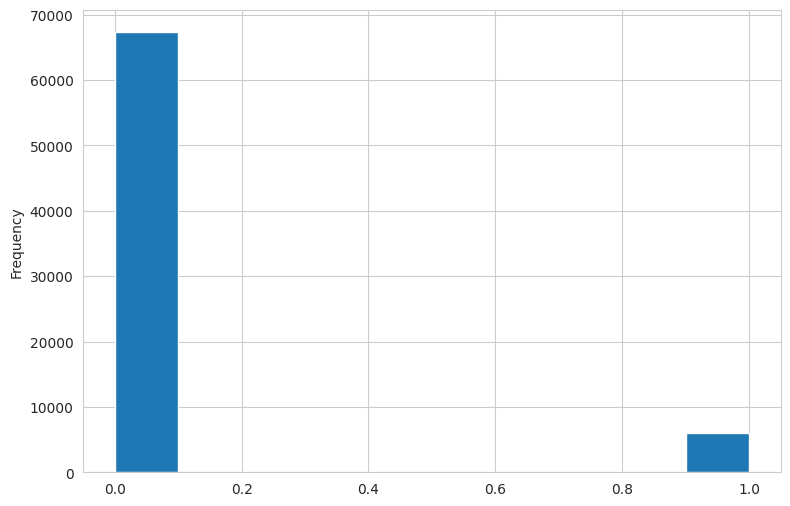

In [ ]:
df_clean['TARGET'].plot.hist()

À partir de ces informations, nous voyons qu’il s’agit d’un problème de classe déséquilibré. Il y a beaucoup plus de prêts remboursés à temps que de prêts non remboursés.

In [ ]:
# Number of each type of column
df_clean.dtypes.value_counts()

float64    290
int64       19
dtype: int64

In [ ]:
df_clean.describe()

SK_ID_CURR        TARGET    CODE_GENDER   CNT_CHILDREN  \
count  121510.000000  73293.000000  121510.000000  121510.000000   
mean   197402.139931      0.081577       0.665130       0.412657   
std     94160.175723      0.273721       0.471947       0.719773   
min    100001.000000      0.000000       0.000000       0.000000   
25%    131653.250000      0.000000       0.000000       0.000000   
50%    163360.500000      0.000000       1.000000       0.000000   
75%    230759.250000      0.000000       1.000000       1.000000   
max    456250.000000      1.000000       1.000000      20.000000   

       AMT_INCOME_TOTAL    AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count      1.215100e+05  1.215100e+05  121480.000000     1.214510e+05   
mean       1.721611e+05  5.620939e+05   27967.872876     5.040752e+05   
std        3.486122e+05  3.834988e+05   14932.114892     3.519716e+05   
min        2.565000e+04  4.500000e+04    1980.000000     4.500000e+04   
25%        1.125000e+05  2.700000e+05   17131.500000     2.250000e+05   
50%        1.575000e+05  4.741830e+05   25447.500000     4.500000e+05   
75%        2.025000e+05  7.551900e+05   35617.500000     6.750000e+05   
max        1.170000e+08  3.956274e+06  225000.000000     3.825000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  ...  \
count               121510.000000  121510.000000  ...   
mean                     0.020882  -16067.937388  ...   
std                      0.013924    4341.422371  ...   
min                      0.000253  -25201.000000  ...   
25%                      0.010006  -19670.000000  ...   
50%                      0.018850  -15794.000000  ...   
75%                      0.028663  -12464.250000  ...   
max                      0.072508   -7338.000000  ...   

       INSTAL_AMT_INSTALMENT_MEAN  INSTAL_AMT_INSTALMENT_SUM  \
count                1.206840e+05               1.206840e+05   
mean                 1.908087e+04               7.012205e+05   
std                  2.480560e+04               9.206090e+05   
min                  1.890000e-01               9.450000e-01   
25%                  8.090770e+03               1.404485e+05   
50%                  1.300688e+04               3.433149e+05   
75%                  2.214621e+04               8.796102e+05   
max                  2.291331e+06               3.247978e+07   

       INSTAL_AMT_PAYMENT_MIN  INSTAL_AMT_PAYMENT_MAX  \
count            1.206820e+05            1.206820e+05   
mean             5.490252e+03            1.436796e+05   
std              1.575253e+04            2.542207e+05   
min              0.000000e+00            2.250000e-01   
25%              4.351500e+01            1.495278e+04   
50%              2.385832e+03            3.880368e+04   
75%              7.298077e+03            1.395794e+05   
max              2.291331e+06            3.473583e+06   

       INSTAL_AMT_PAYMENT_MEAN  INSTAL_AMT_PAYMENT_SUM  \
count             1.206820e+05            1.206840e+05   
mean              1.949967e+04            7.102094e+05   
std               2.648564e+04            9.595606e+05   
min               1.890000e-01            0.000000e+00   
25%               7.779911e+03            1.367980e+05   
50%               1.271513e+04            3.351623e+05   
75%               2.223225e+04            8.750495e+05   
max               2.291331e+06            3.268928e+07   

       INSTAL_DAYS_ENTRY_PAYMENT_MAX  INSTAL_DAYS_ENTRY_PAYMENT_MEAN  \
count                  120682.000000                   120682.000000   
mean                     -330.048765                     -923.583239   
std                       536.353675                      596.204299   
min                     -3071.000000                    -3071.000000   
25%                      -393.000000                    -1311.264039   
50%                       -66.000000                     -805.674242   
75%                       -26.000000                     -437.219925   
max                        -1.00000

 Les nombres de la colonne DAYS_BIRTH sont négatifs car ils sont enregistrés par rapport à la demande de prêt en cours. Pour voir ces statistiques en années, on peut multiplier par -1 et diviser par le nombre de jours dans une année :

In [ ]:
(df_clean['DAYS_BIRTH'] / -365).describe()

count    121510.000000
mean         44.021746
std          11.894308
min          20.104110
25%          34.148630
50%          43.271233
75%          53.890411
max          69.043836
Name: DAYS_BIRTH, dtype: float64

Ces âges semblent raisonnables. Il n’y a pas de valeurs aberrantes pour l’âge, que ce soit dans le haut ou le bas. Et les jours de travail ?

In [ ]:
df_clean['DAYS_EMPLOYED'].describe()

count    99128.000000
mean     -2438.759856
std       2332.899303
min     -17531.000000
25%      -3266.000000
50%      -1712.000000
75%       -819.000000
max          0.000000
Name: DAYS_EMPLOYED, dtype: float64

Cela n'a pas l'air bien ! La valeur maximale (en plus d'être positive) est d'environ 00 ans !

Text(0.5, 0, "Jours d'emploi")

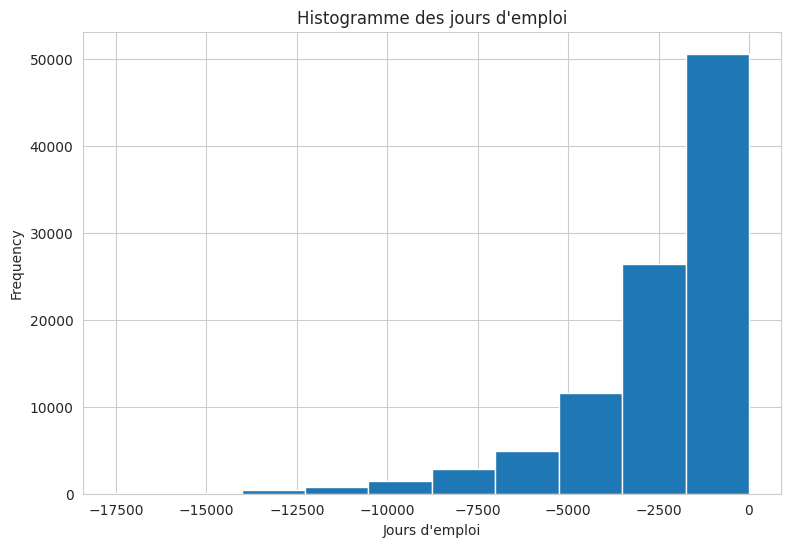

In [ ]:
df_clean['DAYS_EMPLOYED'].plot.hist(title = "Histogramme des jours d'emploi");
plt.xlabel("Jours d'emploi")

Juste par curiosité, divisons les clients anormaux et voyons s'ils ont tendance à avoir des taux de défaut plus élevés ou plus faibles que le reste des clients.

In [ ]:
anom = df_clean[df_clean['DAYS_EMPLOYED'] == 0]
non_anom = df_clean[df_clean['DAYS_EMPLOYED'] != 0]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.16% of loans
The anomalies default on 0.00% of loans
There are 1 anomalous days of employment


Eh bien, c'est extrêmement intéressant ! Il s’avère que les anomalies ont un taux de défaut plus faible.

La gestion des anomalies dépend de la situation exacte, sans règles définies. L'une des approches les plus sûres consiste simplement à définir les anomalies sur une valeur manquante, puis à les remplir (à l'aide de l'imputation) avant l'apprentissage automatique. Dans ce cas, puisque toutes les anomalies ont exactement la même valeur, nous souhaitons les remplir avec la même valeur au cas où tous ces prêts partageraient quelque chose en commun. Les valeurs anormales semblent avoir une certaine importance, nous voulons donc indiquer au modèle d'apprentissage automatique si nous avons effectivement renseigné ces valeurs. Comme solution, nous remplirons les valeurs anormales sans un nombre (np.nan) puis créerons une nouvelle colonne booléenne indiquant si la valeur était anormale ou non.

Corrélations
Maintenant que nous avons traité les variables catégorielles et les valeurs aberrantes, continuons avec l'EDA. Une façon d’essayer de comprendre les données consiste à rechercher des corrélations entre les caractéristiques et la cible. Nous pouvons calculer le coefficient de corrélation de Pearson entre chaque variable et la cible en utilisant la méthode dataframe .corr.

Le coefficient de corrélation n'est pas la meilleure méthode pour représenter la « pertinence » d'une caractéristique, mais il nous donne une idée des relations possibles au sein des données. Voici quelques interprétations générales de la valeur absolue du coefficient de corrélation :

.00-.19 « très faible »
.20-.39 «faible»
.40-.59 « modéré »
.60-.79 « fort »
.80-1.0 « très fort »

In [ ]:
# Find correlations with the target and sort
correlations = df_clean.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 ACTIVE_DAYS_CREDIT_MAX                    0.059678
DAYS_LAST_PHONE_CHANGE                    0.060254
PREV_NAME_PRODUCT_TYPE_walkin_MEAN        0.060334
CLOSED_DAYS_CREDIT_MEAN                   0.060732
REGION_RATING_CLIENT                      0.062295
ACTIVE_DAYS_CREDIT_MEAN                   0.064200
BURO_DAYS_CREDIT_UPDATE_MEAN              0.069721
BURO_MONTHS_BALANCE_MIN_MIN               0.069987
DAYS_EMPLOYED                             0.075560
BURO_DAYS_CREDIT_MIN                      0.076547
DAYS_BIRTH                                0.079818
PREV_NAME_CONTRACT_STATUS_Refused_MEAN    0.081455
BURO_CREDIT_ACTIVE_Active_MEAN            0.083667
BURO_DAYS_CREDIT_MEAN                     0.094367
TARGET                                    1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                              -0.176413
EXT_SOURCE_2                              -0.163276
EXT_SOURCE_1                              -

In [ ]:
df_clean['TARGET'].unique()

array([ 1.,  0., nan])

Trouver la corrélation des jours positifs depuis la naissance et l'objectif

In [ ]:
# Find the correlation of the positive days since birth and target
df_clean['DAYS_BIRTH'] = abs(df_clean['DAYS_BIRTH'])
df_clean['DAYS_BIRTH'].corr(df_clean['TARGET'])

-0.07981831898046174

À mesure que le client vieillit, il existe une relation linéaire négative avec la cible, ce qui signifie qu’à mesure que les clients vieillissent, ils ont tendance à rembourser leurs prêts à temps plus souvent.

Commençons par examiner cette variable. Tout d’abord, nous pouvons faire un histogramme de l’âge. Nous mettrons l'axe des x en années pour rendre l'intrigue un peu plus compréhensible.

Text(0, 0.5, 'Count')

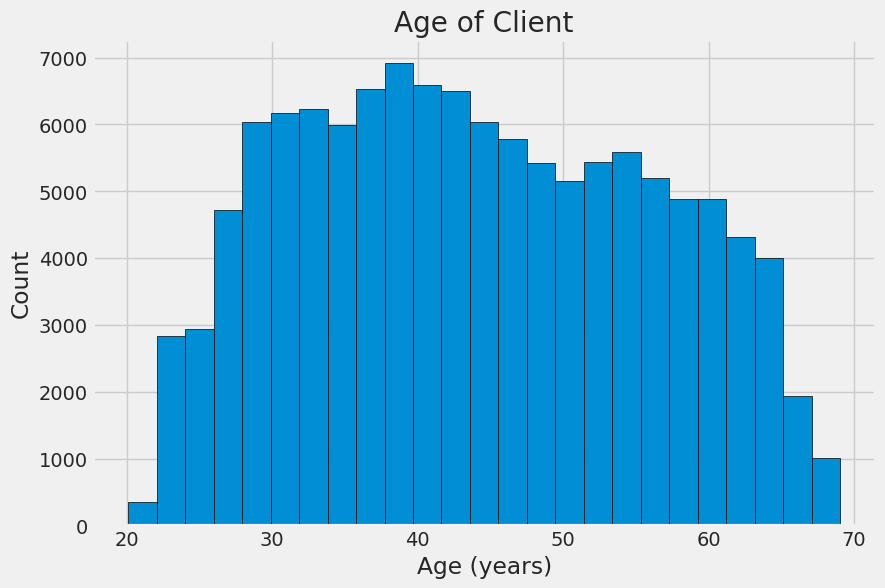

In [ ]:
# Set the style of plots
plt.style.use('fivethirtyeight')

#Tracer la répartition des âges en années
plt.hist(df_clean['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client')
plt.xlabel('Age (years)')
plt.ylabel('Count')

En elle-même, la répartition par âge ne nous dit pas grand-chose, si ce n’est qu’il n’y a pas de valeurs aberrantes puisque tous les âges sont raisonnables. Pour visualiser l'effet de l'âge sur la cible, nous allons ensuite créer un tracé d'estimation de la densité du noyau (KDE) coloré par la valeur de la cible. Un tracé d'estimation de densité de noyau montre la distribution d'une variable unique et peut être considéré comme un histogramme lissé (il est créé en calculant un noyau, généralement un gaussien, à chaque point de données, puis en faisant la moyenne de tous les noyaux individuels pour développer un seul noyau lisse). courbe). Nous utiliserons le kdeplot seaborn pour ce graphique

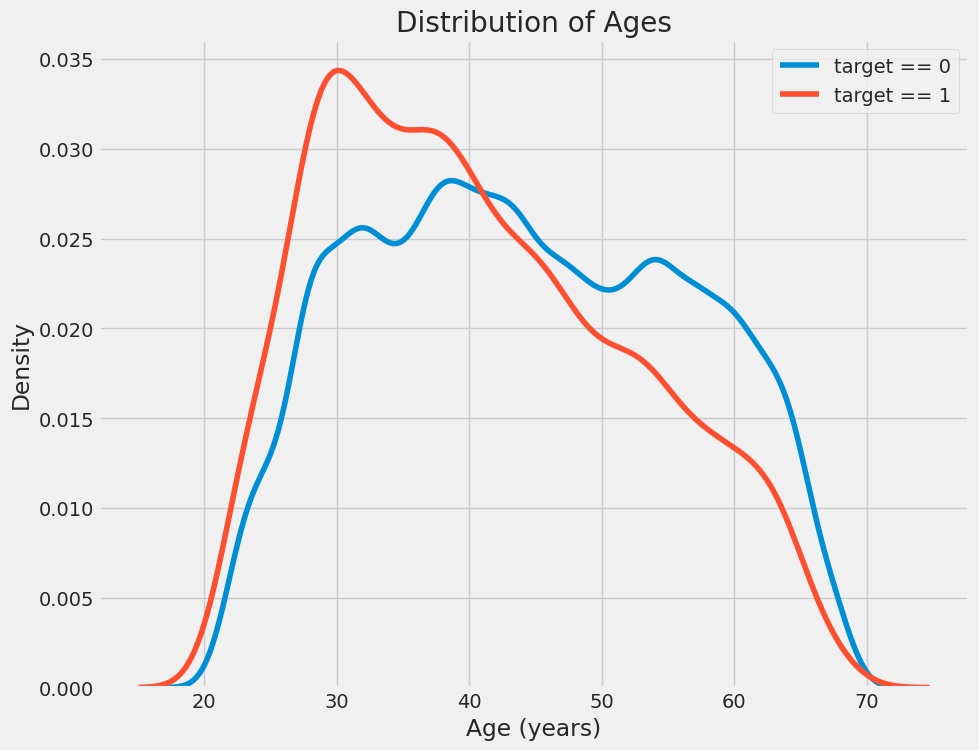

In [ ]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(df_clean.loc[df_clean['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(df_clean.loc[df_clean['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Distribution of Ages')
plt.legend()

La courbe cible == 1 s’incline vers l’extrémité la plus jeune de la fourchette. Bien qu'il ne s'agisse pas d'une corrélation significative (coefficient de corrélation de -0,07), cette variable sera probablement utile dans un modèle d'apprentissage automatique car elle affecte la cible. Examinons cette relation sous un autre angle : non-remboursement moyen des prêts par tranche d'âge.

Pour réaliser ce graphique, nous avons d’abord découpé la catégorie d’âge en tranches de 5 ans chacune. Ensuite, pour chaque case, nous calculons la valeur moyenne de la cible, qui nous indique le ratio de prêts non remboursés dans chaque tranche d'âge.

Sources extérieures¶
Les 3 variables présentant les corrélations négatives les plus fortes avec la cible sont EXT_SOURCE_1, EXT_SOURCE_2 et EXT_SOURCE_3. Selon la documentation, ces fonctionnalités représentent un « score normalisé provenant d'une source de données externe ». Je ne suis pas sûr de ce que cela signifie exactement, mais il peut s'agir d'une sorte de notation de crédit cumulative établie à l'aide de nombreuses sources de données.

Jetons un coup d'œil à ces variables.

Tout d'abord, nous pouvons montrer les corrélations des caractéristiques EXT_SOURCE avec la cible et entre elles.

In [ ]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = df_clean[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.155920     -0.163276     -0.176413   -0.079818
EXT_SOURCE_1 -0.155920      1.000000      0.210651      0.169366    0.566187
EXT_SOURCE_2 -0.163276      0.210651      1.000000      0.104901    0.102574
EXT_SOURCE_3 -0.176413      0.169366      0.104901      1.000000    0.197479
DAYS_BIRTH   -0.079818      0.566187      0.102574      0.197479    1.000000

Text(0.5, 1.0, 'Correlation Heatmap')

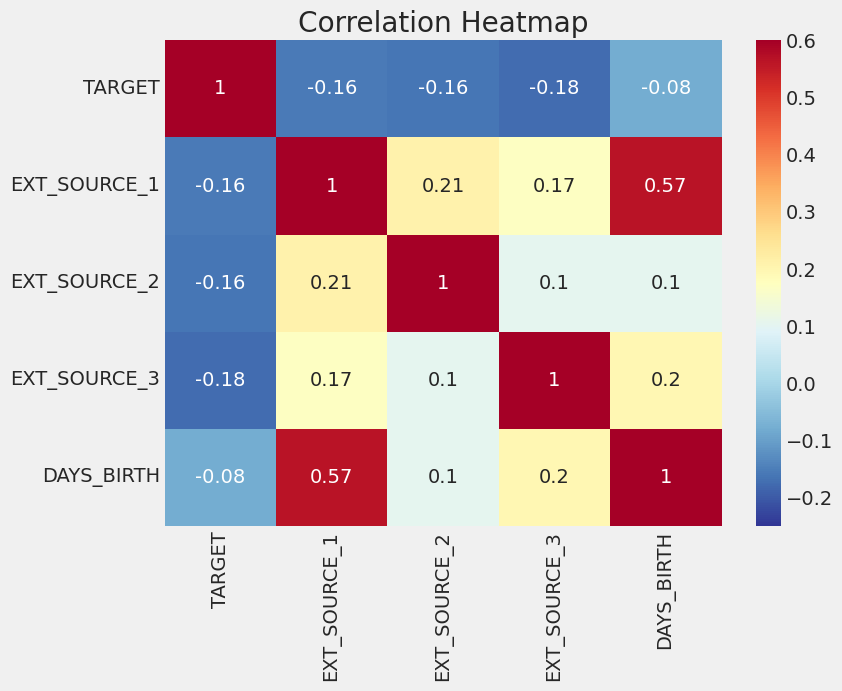

In [ ]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap')

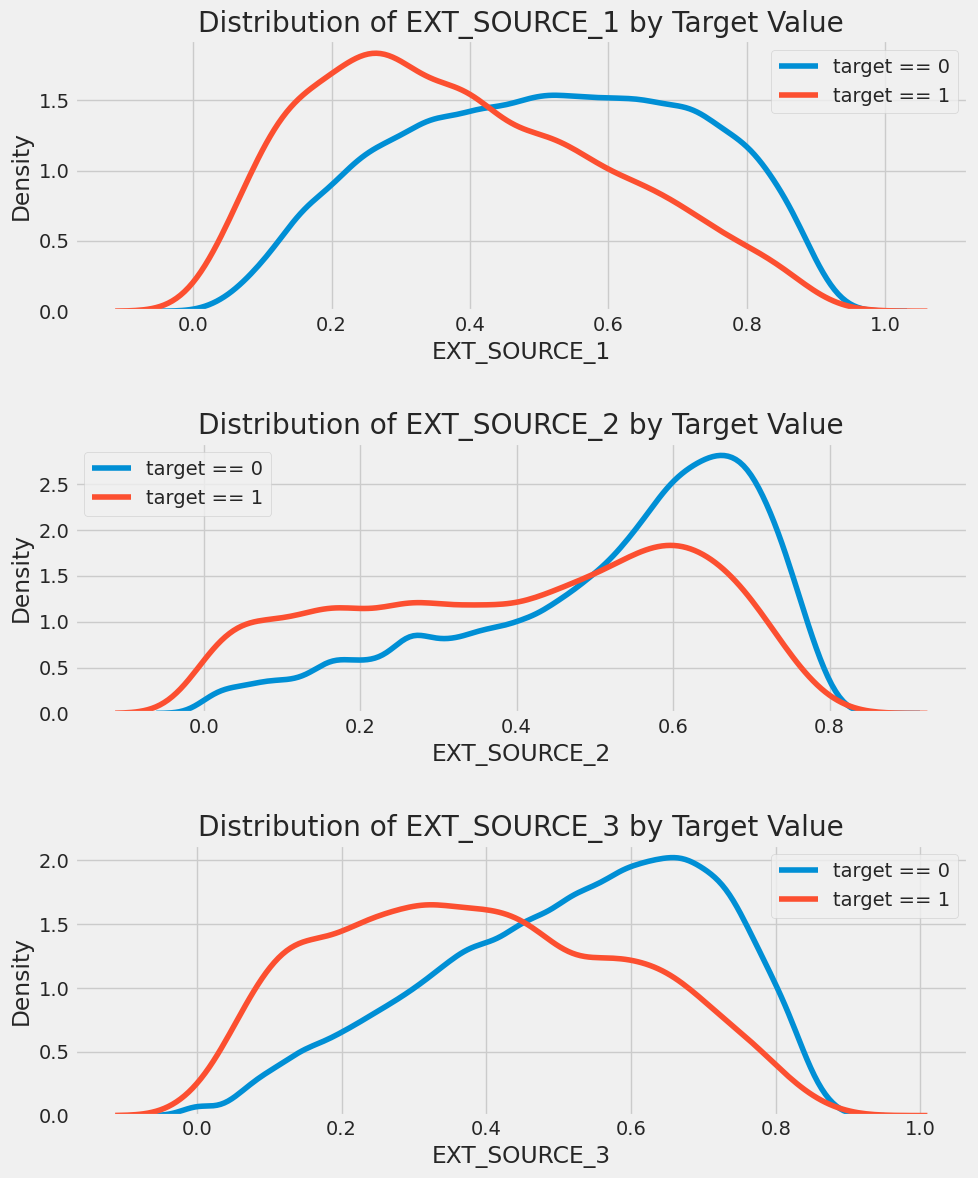

In [ ]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):

    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(df_clean.loc[df_clean['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df_clean.loc[df_clean['TARGET'] == 1, source], label = 'target == 1')

    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density'); plt.legend();

plt.tight_layout(h_pad = 2.5)

Modèle amélioré :
Forêt aléatoire
Pour essayer de vaincre les mauvaises performances de notre base de référence, nous pouvons mettre à jour l'algorithme. Essayons d'utiliser une forêt aléatoire sur les mêmes données d'entraînement pour voir comment cela affecte les performances. La Random Forest est un modèle beaucoup plus puissant surtout lorsque l’on utilise des centaines d’arbres. Nous utiliserons 100 arbres dans la forêt aléatoire.

In [ ]:
from sklearn.metrics import confusion_matrix, make_scorer
# Define a custom scoring function
def custom_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return 10 * fn + fp
# Create a scorer from the custom scoring function
custom_scorer = make_scorer(custom_score, greater_is_better=False)

MLflow

In [ ]:
!pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.0 MB/s eta 0:00:00


In [ ]:
# Remplacer les valeurs infinies par la médiane de chaque colonne
#medians = df_clean.median()  # Calculer la médiane de chaque colonne
#df_clean = df_clean.fillna(medians)

#df_clean.replace(np.inf, medians, inplace=True)
#df_clean.replace(-np.inf, medians, inplace=True)


In [ ]:
df_clean.isna().mean()

SK_ID_CURR                        0.000000
TARGET                            0.396815
CODE_GENDER                       0.000000
CNT_CHILDREN                      0.000000
AMT_INCOME_TOTAL                  0.000000
                                    ...   
INSTAL_AMT_PAYMENT_SUM            0.006798
INSTAL_DAYS_ENTRY_PAYMENT_MAX     0.006814
INSTAL_DAYS_ENTRY_PAYMENT_MEAN    0.006814
INSTAL_DAYS_ENTRY_PAYMENT_SUM     0.006798
INSTAL_COUNT                      0.006798
Length: 309, dtype: float64

Démarrer d'un serveur de suivi MLflow local, auquel nous nous connecterons pour enregistrer nos données pour ce démarrage rapide

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Diviser les données avec des valeurs cibles non-NaN
df_application_train = df_clean[df_clean['TARGET'].notnull()]
df_application_test = df_clean[df_clean['TARGET'].isnull()]
X = df_application_train.drop('TARGET', axis=1)
medians = X.median()  # Calculer la médiane de chaque colonne
X.replace(np.inf, medians, inplace=True)
X.replace(-np.inf, medians, inplace=True)
X = X.fillna(medians)
y = df_application_train['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
df_application_train["TARGET"].isna().sum()

0

In [ ]:
df_application_test["TARGET"].isna().sum()

48217

In [ ]:
X_train.shape, y_train.shape

((58634, 308), (58634,))

In [ ]:
X_test.shape, y_test.shape

((14659, 308), (14659,))

In [ ]:
np.bincount(y_test)

array([13467,  1192])

In [ ]:
np.bincount(y_train)

array([53847,  4787])

In [ ]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import mlflow
mlflow.set_experiment("RandomForestClassifier")
mlflow.sklearn.autolog()
# Start an MLflow run
with mlflow.start_run(run_name="randomforestclassifier_defaut"):
  # Instancier le RandomForestClassifier
  rf_classifier = RandomForestClassifier(random_state=42)
  # Entraîner le modèle sur l'ensemble d'entraînement
  rf_classifier.fit(X_train_scaled, y_train)


2024/01/12 06:46:33 INFO mlflow.tracking.fluent: Experiment with name 'RandomForestClassifier' does not exist. Creating a new experiment.
2024/01/12 06:46:37 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2024/01/12 06:49:22 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


In [ ]:
# Second run
with mlflow.start_run(run_name="randomforestclassifier_parametres"):
  # Instancier le RandomForestClassifier
  rf_classifier = RandomForestClassifier(n_estimators=150, verbose=1, n_jobs=-1, random_state=42)
  # Entraîner le modèle sur l'ensemble d'entraînement
  rf_classifier.fit(X_train_scaled, y_train)

2024/01/12 06:51:04 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.6min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:    4.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:    4.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:    4.2s fini

Entraîner un modèle et préparer les métadonnées pour la journalisation

In [ ]:
import mlflow
from mlflow.models import infer_signature

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define the model hyperparameters
params = {
    "solver": "lbfgs",
    "max_iter": 1000,
    "multi_class": "auto",
    "random_state": 8888,
}

# Train the model
lr = LogisticRegression(**params)
lr.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = lr.predict(X_test_scaled)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)


2024/01/12 06:56:04 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ee7ada603c8c43708ad6a4228b7ed36a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/01/12 06:56:04 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


Enregistrer le modèle et ses métadonnées dans MLflow


In [ ]:
# Set our tracking server uri for logging
#mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

import mlflow
mlflow.set_experiment("LogisticRegressor")
mlflow.sklearn.autolog()
# Start an MLflow run
with mlflow.start_run(run_name="LogisticRegressor_params"):
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("accuracy", accuracy)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Basic LR model for iris data")

    # Infer the model signature
    signature = infer_signature(X_train, lr.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=lr,
        artifact_path="iris_model",
        signature=signature,
        input_example=X_train,
        registered_model_name="tracking-quickstart",
    )


2024/01/12 06:57:00 INFO mlflow.tracking.fluent: Experiment with name 'LogisticRegressor' does not exist. Creating a new experiment.
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
2024/01/12 06:57:05 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.10/dist-packages/mlflow/data/pandas_dataset.py:134: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See

In [ ]:
!pip install pyngrok

In [ ]:
from pyngrok import ngrok
ngrok.kill()
NGROK_AUTH_TOKEN = "2aNPefgrIjAkRjqX23Zzjt73Dh0_4xz7CEyDeob3NuGDF2k9R"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Traking UI :", ngrok_tunnel.public_url)

MLflow Traking UI : https://0f51-34-74-59-26.ngrok-free.app


In [ ]:
!mlflow ui

[2024-01-12 06:58:26 +0000] [6533] [INFO] Starting gunicorn 21.2.0
[2024-01-12 06:58:26 +0000] [6533] [INFO] Listening at: http://127.0.0.1:5000 (6533)
[2024-01-12 06:58:26 +0000] [6533] [INFO] Using worker: sync
[2024-01-12 06:58:26 +0000] [6538] [INFO] Booting worker with pid: 6538
[2024-01-12 06:58:26 +0000] [6539] [INFO] Booting worker with pid: 6539
[2024-01-12 06:58:26 +0000] [6540] [INFO] Booting worker with pid: 6540
[2024-01-12 06:58:26 +0000] [6541] [INFO] Booting worker with pid: 6541


[2024-01-12 07:01:41 +0000] [6533] [INFO] Handling signal: int

Aborted!
[2024-01-12 07:01:42 +0000] [6538] [INFO] Worker exiting (pid: 6538)
[2024-01-12 07:01:42 +0000] [6540] [INFO] Worker exiting (pid: 6540)
[2024-01-12 07:01:42 +0000] [6539] [INFO] Worker exiting (pid: 6539)
[2024-01-12 07:01:42 +0000] [6541] [INFO] Worker exiting (pid: 6541)
[2024-01-12 07:01:44 +0000] [6533] [INFO] Shutting down: Master


Chargez le modèle en tant que fonction Python (pyfunc) et utilisez-le pour l'inférence


In [ ]:
from sklearn import ensemble, pipeline
pipeline = pipeline.Pipeline([('scaler', preprocessing.StandardScaler()),
                              ('randomForestClassifier', ensemble.RandomForestClassifier())])

In [ ]:
pipeline.fit(X_train_scaled, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('randomForestClassifier', RandomForestClassifier())])

In [ ]:
from sklearn.metrics import confusion_matrix, make_scorer
# Define a custom scoring function
def custom_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return 10 * fn + fp
# Create a scorer from the custom scoring function
custom_scorer = make_scorer(custom_score, greater_is_better=False)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
params = {'n_estimators': [100, 150, 200],
          'max_depth': [2, 3, 5],
          'min_samples_leaf': [3, 5, 7]
          }
score = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'custom_scorer':custom_scorer
}

  # Instancier le RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)
gsv = model_selection.GridSearchCV(rf_classifier, param_grid = params, cv=5, scoring=score, refit="custom_scorer")
gsv.fit(X_train_scaled, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(gsv.best_params_)
print('\nBest mean_test Score : %.2f'%gsv.best_score_, ' Best Params : ', str(gsv.best_params_))


# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
print(gsv.cv_results_.keys())
for mean_test_custom_scorer, mean_test_f1,  mean_test_accuracy, params in zip(
        gsv.cv_results_['mean_test_custom_scorer'], # score moyen
        gsv.cv_results_['mean_test_f1'],  # écart-type du score
        gsv.cv_results_['mean_test_accuracy'],
        gsv.cv_results_['params']          # valeur de l'hyperparamètre
    ):

    print("mean_test_score: {}, mean_test_f1: {}, mean_test_accuracy: {} for params: {}".format(
        mean_test_custom_scorer,
        mean_test_f1,
        mean_test_accuracy,
        params
    ) )


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'max_depth': 2, 'min_samples_leaf': 3, 'n_estimators': 100}

Best mean_test Score : -9574.00  Best Params :  {'max_depth': 2, 'min_samples_leaf': 3, 'n_estimators': 100}
Résultats de la validation croisée :
dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_min_samples_leaf', 'param_n_estimators', 'params', 'split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy', 'split0_test_precision', 'split1_test_precision', 'split2_test_precision', 'split3_test_precision', 'split4_test_precision', 'mean_test_precision', 'std_test_precision', 'rank_test_precision', 'split0_test_recall', 'split1_test_recall', 'split2_test_recall', 'split3_test_recall', 'split4_test_recall', 'mean_test_recall', 'std_test_recall', 'rank_test_recall', 'split0_test_f1', 'split1_test

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection

import mlflow
mlflow.set_experiment("RandomForestClassifier")
mlflow.sklearn.autolog()
# Start an MLflow run
with mlflow.start_run(run_name="randomforestclassifier_defaut"):
  # Instancier le RandomForestClassifier
  gsv= RandomForestClassifier(random_state=42)
  gsv.fit(X_train_scaled, y_train)

2024/01/07 10:38:50 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection

import mlflow
mlflow.set_experiment("RandomForestClassifier")
mlflow.sklearn.autolog()
# Start an MLflow run
with mlflow.start_run(run_name="randomforestclassifier_paramsGrid"):
  # Instancier le RandomForestClassifier
  rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=2, min_samples_leaf=30, random_state=42)
  #gsv = model_selection.GridSearchCV(rf_classifier, params, cv=5)
  rf_classifier.fit(X_train_scaled, y_train)

2024/01/07 07:11:06 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
!pip install pyngrok

In [ ]:
from pyngrok import ngrok
ngrok.kill()
NGROK_AUTH_TOKEN = "2aNPefgrIjAkRjqX23Zzjt73Dh0_4xz7CEyDeob3NuGDF2k9R"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Traking UI :", ngrok_tunnel.public_url)

MLflow Traking UI : https://66b7-35-204-227-204.ngrok-free.app


In [ ]:
!mlflow ui

[2024-01-07 07:12:09 +0000] [13340] [INFO] Starting gunicorn 21.2.0
[2024-01-07 07:12:09 +0000] [13340] [INFO] Listening at: http://127.0.0.1:5000 (13340)
[2024-01-07 07:12:09 +0000] [13340] [INFO] Using worker: sync
[2024-01-07 07:12:09 +0000] [13341] [INFO] Booting worker with pid: 13341
[2024-01-07 07:12:09 +0000] [13342] [INFO] Booting worker with pid: 13342
[2024-01-07 07:12:09 +0000] [13343] [INFO] Booting worker with pid: 13343
[2024-01-07 07:12:09 +0000] [13344] [INFO] Booting worker with pid: 13344


[2024-01-07 07:15:07 +0000] [13340] [INFO] Handling signal: int
[2024-01-07 07:15:07 +0000] [13341] [INFO] Worker exiting (pid: 13341)
[2024-01-07 07:15:07 +0000] [13342] [INFO] Worker exiting (pid: 13342)
[2024-01-07 07:15:07 +0000] [13344] [INFO] Worker exiting (pid: 13344)
[2024-01-07 07:15:07 +0000] [13343] [INFO] Worker exiting (pid: 13343)

Aborted!
[2024-01-07 07:15:10 +0000] [13340] [INFO] Shutting down: Master


Feature importance via shape

In [ ]:
labels = df_clean.columns
print(labels)

Index(['SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       ...
       'INSTAL_AMT_INSTALMENT_MEAN', 'INSTAL_AMT_INSTALMENT_SUM',
       'INSTAL_AMT_PAYMENT_MIN', 'INSTAL_AMT_PAYMENT_MAX',
       'INSTAL_AMT_PAYMENT_MEAN', 'INSTAL_AMT_PAYMENT_SUM',
       'INSTAL_DAYS_ENTRY_PAYMENT_MAX', 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
       'INSTAL_DAYS_ENTRY_PAYMENT_SUM', 'INSTAL_COUNT'],
      dtype='object', length=309)


In [ ]:
#@title
!pip install -q shap umap-learn lime
!curl -L -O https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 17.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 6.8 MB/s eta 0:00:00
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  947k  100  947k    0     0  2198k      0 --:--:-- --:--:-- --:--:-- 2198k


In [ ]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import classification_report


import shap
from lime.lime_tabular import LimeTabularExplainer
import xgboost
import seaborn as sns;
import umap


import matplotlib.pyplot as plt
import matplotlib

idcol = 'customerID'
labelcol = 'Churn'
cols = (('gender', True),
        ('SeniorCitizen', True),
        ('Partner', True),
        ('Dependents', True),
        ('tenure', False),
        ('PhoneService', True),
        ('MultipleLines', True),
        ('InternetService', True),
        ('OnlineSecurity', True),
        ('OnlineBackup', True),
        ('DeviceProtection', True),
        ('TechSupport', True),
        ('StreamingTV', True),
        ('StreamingMovies', True),
        ('Contract', True),
        ('PaperlessBilling', True),
        ('PaymentMethod', True),
        ('MonthlyCharges', False),
        ('TotalCharges', False))

def drop_non_features(df, cols):
    return df[[c for c, _ in cols]]

def drop_missing(df):
    '''Remove rows with missing values'''
    return df.replace(r'^\s$', np.nan, regex=True).dropna()


def clean(df):
    # Make target variable a true boolean column
    # Drop unpredictive column
    df.drop(['customerID'], axis=1)

def categorize(df, cols):
    catcols = (c for c, iscat in cols if iscat)
    for col in catcols:
        df[col] = pd.Categorical(df[col])
    return df

def booleanize_senior_citizen(df):
    '''Make SeniorCitizen 'Yes'/'No' like other columns in this dataset.'''
    return df.replace({'SeniorCitizen': {1: 'Yes', 0: 'No'}})

def splitdf(df, label):
    return df.drop(label, axis=1), df[label]

def load_dataset():
    '''Return IBM customers and labels.'''
    df = pd.read_csv("Telco-Customer-Churn.csv")
    df = drop_missing(df).reset_index()
    df.index.name = 'id'
    features, labels =  splitdf(df, labelcol)
    features = booleanize_senior_citizen(features)
    features = drop_non_features(features, cols)
    features = categorize(features, cols)
    labels = (labels == 'Yes')
    return features, labels

def setup_plot():
  plt.rcParams["axes.grid.axis"] ="y"
  plt.rcParams["axes.grid"] = True
  plt.rcParams["legend.fontsize"] = 14
  plt.rc('grid', linestyle="dashed", color='lightgrey', linewidth=1)
  plt.rcParams["xtick.labelsize"] = 15
  plt.rcParams["ytick.labelsize"]  = 15

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

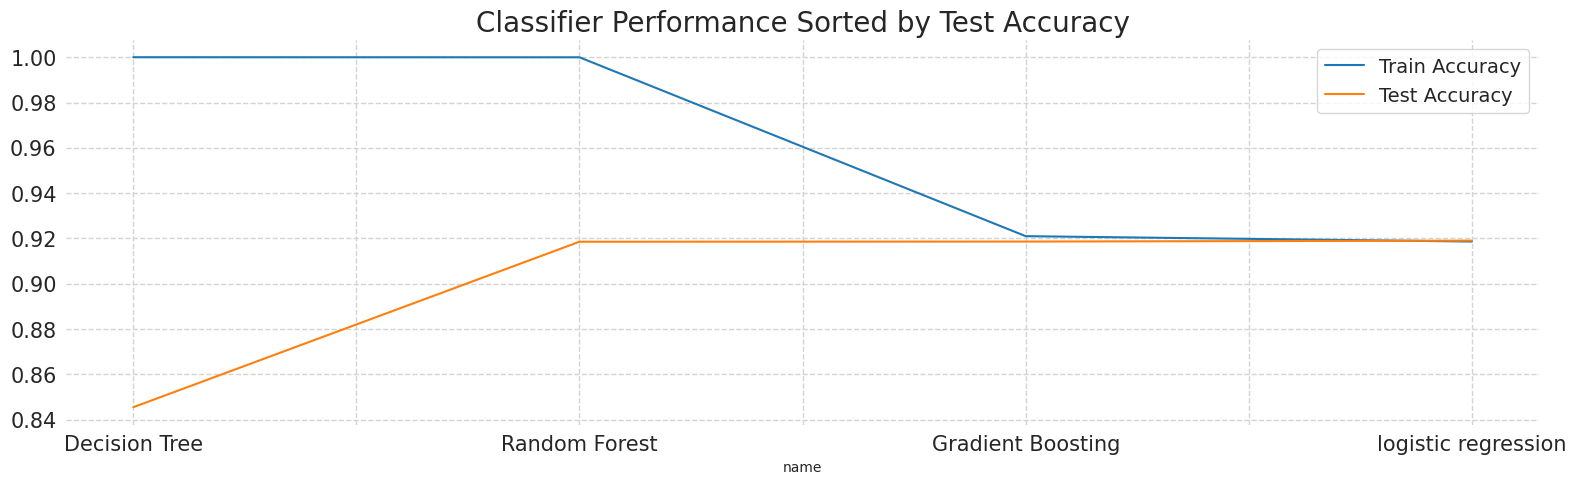

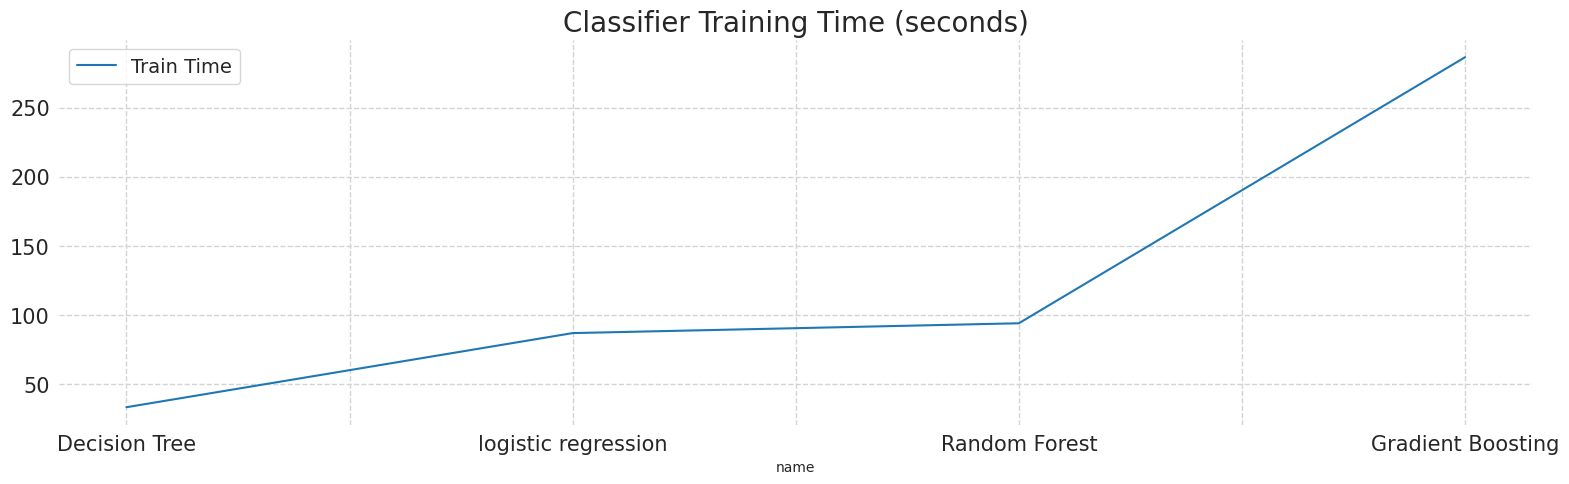

In [ ]:
#@title
import time
import matplotlib.pyplot as plt
from sklearn import ensemble, pipeline
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV

trained_models = [] #  keep track of all details for models we train
def train_model(model, data, labels):
  labels = df_clean.columns
# Diviser les données avec des valeurs cibles non-NaN
  df_application_train = df_clean[df_clean['TARGET'].notnull()]
  df_application_test = df_clean[df_clean['TARGET'].isnull()]
  X = df_application_train.drop('TARGET', axis=1)
  medians = X.median()  # Calculer la médiane de chaque colonne
  X.replace(np.inf, medians, inplace=True)
  X.replace(-np.inf, medians, inplace=True)
  X = X.fillna(medians)
  y = df_application_train['TARGET']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

  pipe = pipeline.Pipeline([('scaler', preprocessing.StandardScaler()),('clf', model["clf"])])
  start_time = time.time()
  pipe.fit(X_train, y_train)
  train_time = time.time() - start_time

  train_accuracy =  pipe.score(X_train, y_train)
  test_accuracy = pipe.score(X_test, y_test)
  model_details = {"name": model["name"], "train_accuracy":train_accuracy, "test_accuracy":test_accuracy, "train_time": train_time, "model": pipe}
  return model_details

models = [
          {"name": "logistic regression", "clf": LogisticRegressionCV()},
          {"name": "Decision Tree", "clf": DecisionTreeClassifier()},
          {"name": "Random Forest", "clf": RandomForestClassifier(n_estimators=100)},
          {"name": "Gradient Boosting", "clf": GradientBoostingClassifier(n_estimators=100)}]

for model in models:
  model_details = train_model(model, df_clean, labels)
  trained_models.append(model_details)


# visualize accuracy and run time
setup_plot()
model_df = pd.DataFrame(trained_models)
model_df.sort_values("test_accuracy", inplace=True)
ax = model_df[["train_accuracy","test_accuracy", "name"]].plot(kind="line", x="name", figsize=(19,5), title="Classifier Performance Sorted by Test Accuracy")
ax.legend(["Train Accuracy", "Test Accuracy"])
for p in ax.patches:
    ax.annotate( str( round(p.get_height(),3) ), (p.get_x() * 1.005, p.get_height() * 1.005))

ax.title.set_size(20)
plt.box(False)

model_df.sort_values("train_time", inplace=True)
ax= model_df[["train_time","name"]].plot(kind="line", x="name", figsize=(19,5), grid=True, title="Classifier Training Time (seconds)")
ax.title.set_size(20)
ax.legend(["Train Time"])
plt.box(False)

### Explications via les scores d'importance des fonctionnalités [Modèles basés sur des arbres]
Les modèles arborescents ont des propriétés qui nous permettent de déduire l'importance d'une fonctionnalité. Pour chaque arbre de décision, nous pouvons calculer la diminution moyenne des impuretés pour chaque caractéristique, c'est-à-dire l'impact de la caractéristique sur la réduction de l'incertitude (classificateurs) ou de la variance (régresseurs) de la prédiction de l'arbre de décision. Cette valeur est également connue sous le nom de score d’importance Gini. Pour chaque modèle arborescent de notre liste de modèles entraînés, nous pouvons tirer parti de l'implémentation sklearn feature_importance et visualiser l'importance moyenne de chaque variable.

Text(0.5, 0.98, 'Feature Importance for Tree Models. Top 20 Features.')

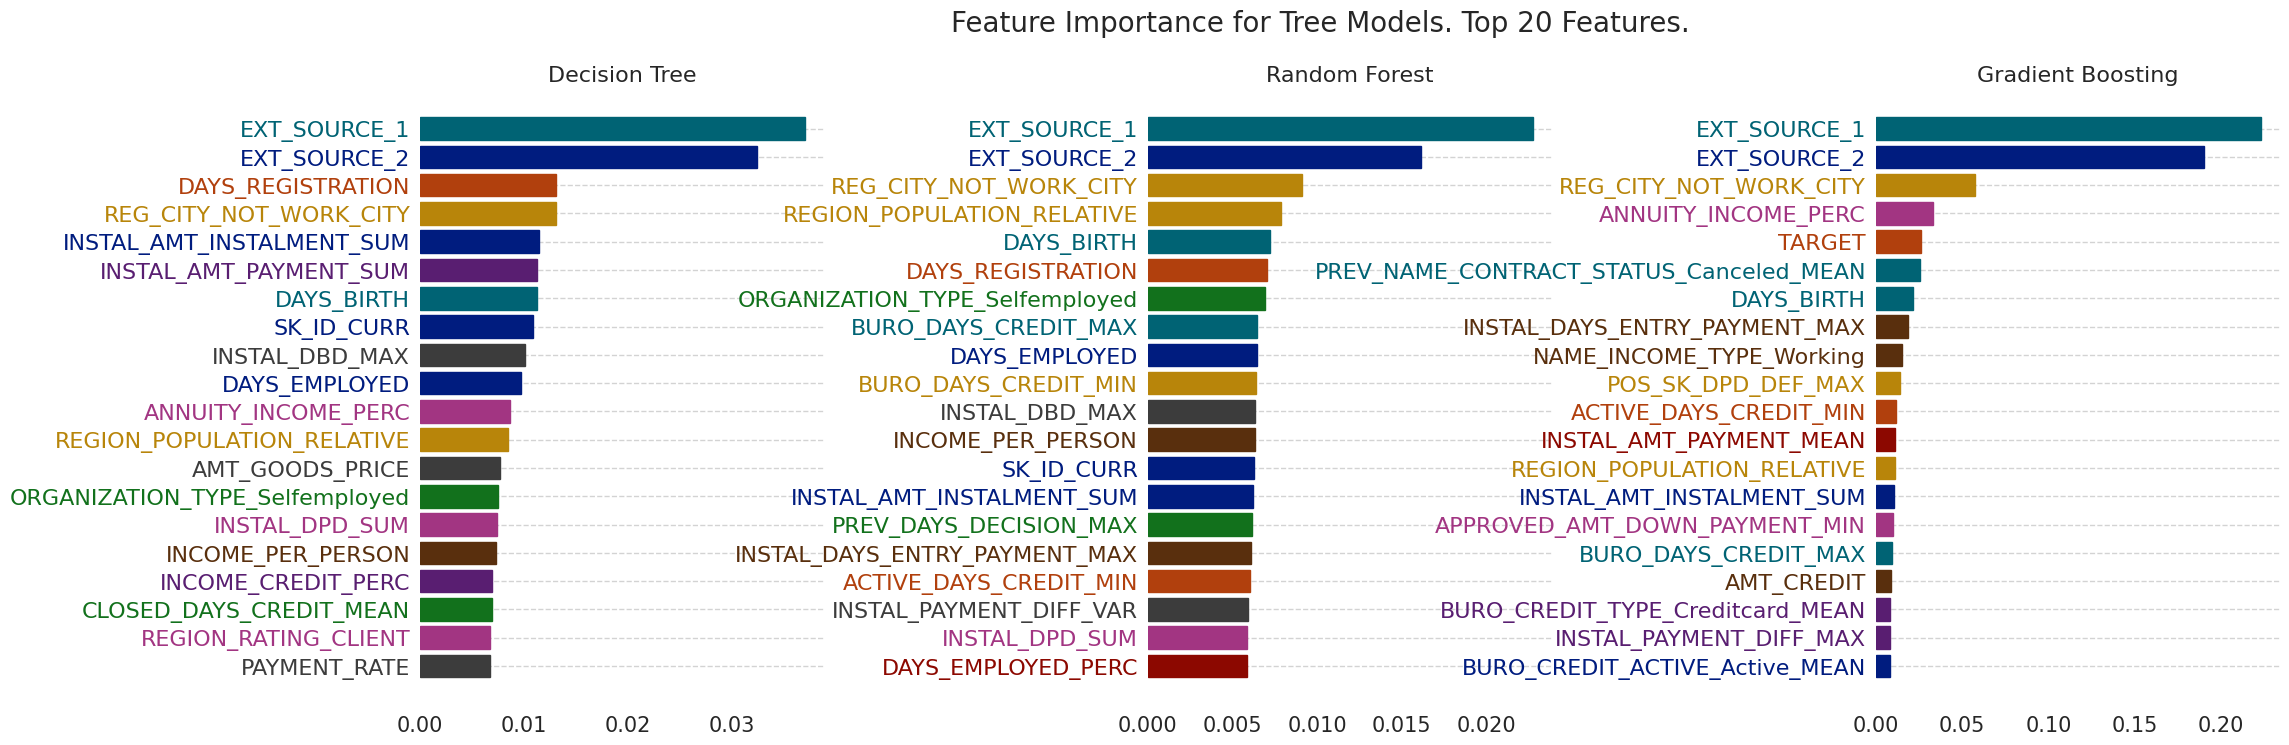

In [ ]:
#@title
# Create array of tree based models and plot feature importance scores
tree_models = []
setup_plot()
color_list =  sns.color_palette("dark", len(df_clean.columns))
top_x = 20 # number of x most important features to show
for model in trained_models:
  if hasattr(model["model"]["clf"], 'feature_importances_'):
    tree_models.append({"name":model["name"], "fi": model["model"]["clf"].feature_importances_})


fig, axs = plt.subplots(1,3, figsize=(24, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0.8)
axs = axs.ravel()
for i in range(len(tree_models)):
  feature_importance = tree_models[i]["fi"]
  indices = np.argsort(feature_importance)
  indices = indices[-top_x:]

  bars = axs[i].barh(range(len(indices)), feature_importance[indices], color='b', align='center')
  axs[i].set_title( tree_models[i]["name"], fontweight="normal", fontsize=16)

  plt.sca(axs[i])
  plt.yticks(range(len(indices)), [df_clean.columns[j] for j in indices], fontweight="normal", fontsize=16)

  # print(len(plt.gca().get_yticklabels()), len(indices))
  for i, ticklabel in enumerate(plt.gca().get_yticklabels()):
    ticklabel.set_color(color_list[indices[i]])

  for i,bar in enumerate(bars):
    bar.set_color(color_list[indices[i]])
  plt.box(False)

plt.suptitle("Feature Importance for Tree Models. Top " + str(top_x) + " Features.", fontsize=20, fontweight="normal")

Ces valeurs d’importance des fonctionnalités semblent intéressantes. Les trois modèles semblent classer systématiquement les frais mensuels, les frais totaux, le contrat et la durée d'occupation parmi les 5 principales caractéristiques saillantes, ce qui suggère qu'il s'agit de caractéristiques importantes.

Il y a ici plusieurs limites.

Les scores d'importance des caractéristiques sont relatifs, ce qui rend difficile leur interprétation par rapport au résultat prévu. Bien qu'ils nous disent que le total des frais est relativement plus important que le contrat pour le modèle d'arbre de décision, ils ne nous disent pas dans quelle mesure une augmentation de 1 $ USD du total des frais affecte la probabilité de désabonnement d'un client.

Les mesures d’importance des fonctionnalités sont des estimations globales sur l’ensemble de données d’entraînement. Pour un sous-ensemble de clients, au sein du même modèle, l'ordre et l'ampleur de l'importance des fonctionnalités peuvent changer (voir la section ci-dessous sur les explications des instances locales). Ainsi, même si nous savons que le total des frais est important en moyenne, nous ne pouvons pas répondre avec certitude à la question : comment le total des frais affecte-t-il un client spécifique ?

Il existe des biais connus liés à la manière dont le score d'importance des fonctionnalités est calculé. Voir (Biais dans les mesures d'importance des variables aléatoires de forêt : illustrations, sources et une solution)

Ces limites rendent souhaitable l’exploration d’explications locales.

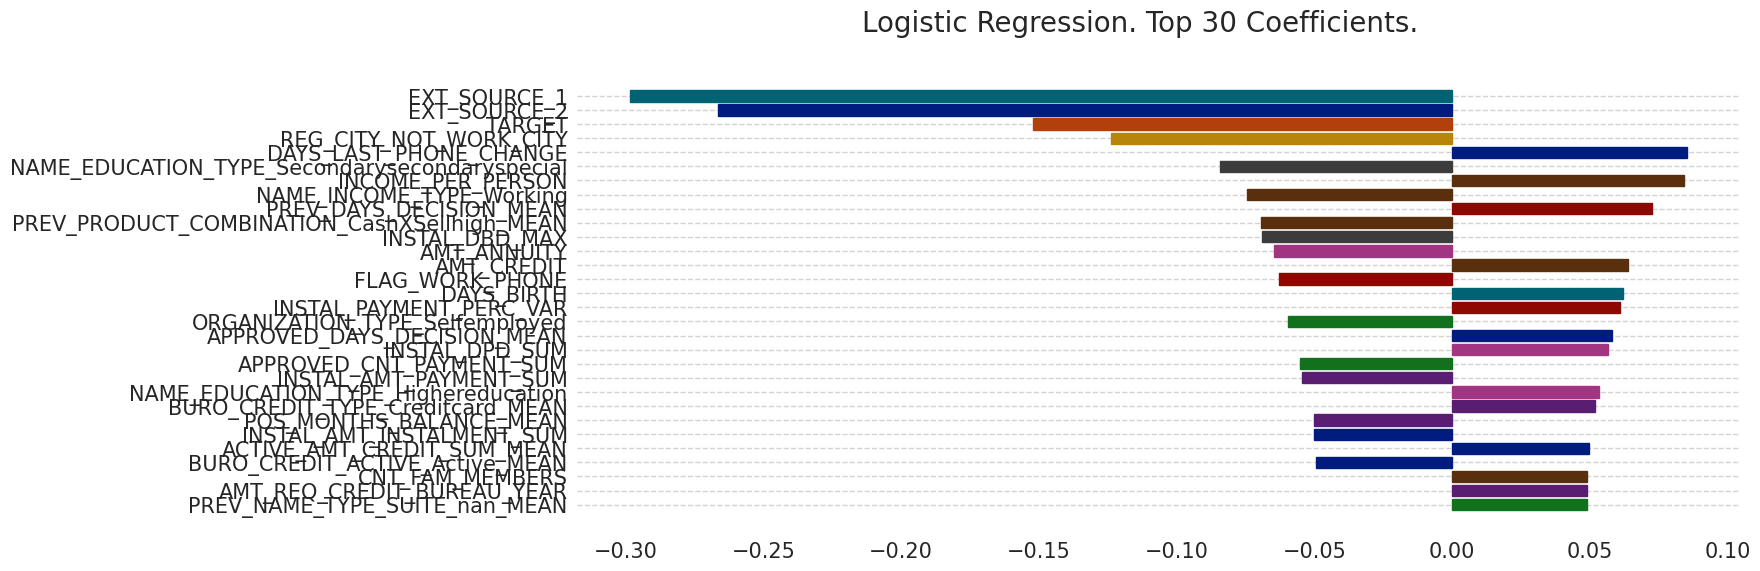

In [ ]:
plt.figure(figsize=(15,6))
#X_train, X_test, y_train, y_test = train_test_split(current_data, labels.values, random_state=42)
logistic_reg_coeff = trained_models[0]["model"]["clf"].coef_
color_list =  sns.color_palette("dark", len(df_clean.columns))
top_x = 30
logistic_reg_coeff = trained_models[0]["model"]["clf"].coef_[0]
idx = np.argsort(np.abs(logistic_reg_coeff))[::-1]
lreg_ax = plt.barh(df_clean.columns[idx[:top_x]][::-1], logistic_reg_coeff[idx[:top_x]][::-1])
for i,bar in enumerate(lreg_ax):
  bar.set_color(color_list[idx[:top_x][::-1][i]])
  plt.box(False)
lr_title = plt.suptitle("Logistic Regression. Top " + str(top_x) + " Coefficients.", fontsize=20, fontweight="normal")

### Explications avec SHAP
Pour donner une idée du fonctionnement de SHAP, considérons le scénario suivant. Nous avons un groupe de data scientists (Sarah, Jessica et Patrick) qui collaborent pour créer un excellent modèle prédictif pour leur entreprise. À la fin de l'année, leurs efforts se traduisent par une augmentation des bénéfices dont 5 millions de dollars doivent désormais être partagés entre nos 3 héros. En supposant que nous disposions de bons moyens de mesurer (ou de simuler) les contributions de chaque data scientist, comment pouvons-nous répartir ce bénéfice de manière à ce que chaque personne soit équitablement récompensée, à la hauteur de sa contribution réelle ?

Les valeurs de Shapley fournissent une méthode pour ce type spécifique d'allocation (environnement de jeu multijoueur collaboratif) avec un ensemble de propriétés axiomatiques souhaitables (efficacité, symétrie, linéarité, anonymat, marginalisme) qui garantissent l'équité. Ces valeurs sont calculées en calculant la contribution marginale moyenne de chaque personne dans tous les classements possibles. Par exemple, imaginez que nous affectons uniquement Sarah au projet et notons l'augmentation du profit (leur contribution marginale). On ajoute ensuite Jessica et notons l'augmentation correspondante. On ajoute ensuite Patrick et notons leur contribution. Ceci est répété pour toutes les commandes possibles (par exemple {Patrick, Jessica, Sarah}, {Jessica, Sarah, Patrick}, etc.) et la contribution marginale moyenne de chaque personne est calculée. En élargissant cela à l'apprentissage automatique, nous pouvons considérer chaque fonctionnalité comme comparable à celle de nos data scientists et la prédiction du modèle comme les bénéfices. Pour expliquer notre modèle, nous ajoutons à plusieurs reprises chaque fonctionnalité et notons sa contribution marginale à la prédiction du modèle. Il est important de noter que nous souhaitons utiliser les valeurs de Shapley pour attribuer un crédit à chaque fonctionnalité, car elles fournissent deux garanties importantes (par exemple, LIME, Permutation des fonctionnalités, Importance des fonctionnalités) que les autres méthodes ne fournissent pas :

précision locale (un modèle approximatif utilisé pour expliquer le modèle d'origine doit correspondre à la sortie du modèle d'origine pour une entrée donnée)
cohérence (si le modèle d'origine change de telle sorte qu'une fonctionnalité a un impact plus important dans chaque ordre possible, alors son attribution ne devrait pas diminuer)
En pratique, quelques simplifications sont nécessaires pour calculer les valeurs de Shapley. Le plus important est peut-être lié à la façon dont nous simulons l’ajout ou la suppression de fonctionnalités lors du calcul de la prédiction du modèle. Cela représente un défi car il n'existe pas de moyen simple de « supprimer » une fonctionnalité pour la plupart des modèles prédictifs au moment du test. Nous pouvons soit remplacer la caractéristique par sa valeur moyenne, valeur médiane. Dans l'implémentation de la bibliothèque SHAP, une fonctionnalité « manquante » est simulée en remplaçant la fonctionnalité par les valeurs qu'elle prend dans l'ensemble de données d'arrière-plan.

### La mise en œuvre de la bibliothèque SHAP.
La bibliothèque SHAP contient des implémentations pour plusieurs types d'explications qui exploitent les valeurs de Shapley. Ceux-ci incluent TreeExplainer qui est optimisé (et rapide) pour les modèles basés sur des arbres ; DeepExplainer et GradientExplainer pour les réseaux de neurones ; et KernelExplainer, qui ne fait aucune hypothèse sur le modèle sous-jacent à expliquer (indépendant du modèle comme LIME).

Pour expliquer un modèle sur un ensemble de test à l'aide de KernelExplainer, l'API de la bibliothèque SHAP est la suivante :

In [ ]:
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.kernel.execute("initjs()")'))

<IPython.core.display.Javascript object>

In [ ]:
print(model["model"]["clf"])

GradientBoostingClassifier()


In [ ]:
import shap
scaled_train_data = scaler.transform(X_train)
sub_sampled_train_data = shap.sample(scaled_train_data, 600, random_state=0)
explainer = shap.KernelExplainer(model["model"]["clf"].predict_proba, sub_sampled_train_data)
test_data_index=10
scaled_test_data = scaler.transform(X_test)
subsampled_test_data =scaled_test_data[test_data_index].reshape(1,-1)
shap_values = explainer.shap_values(subsampled_test_data)

  0%|          | 0/1 [00:00<?, ?it/s]

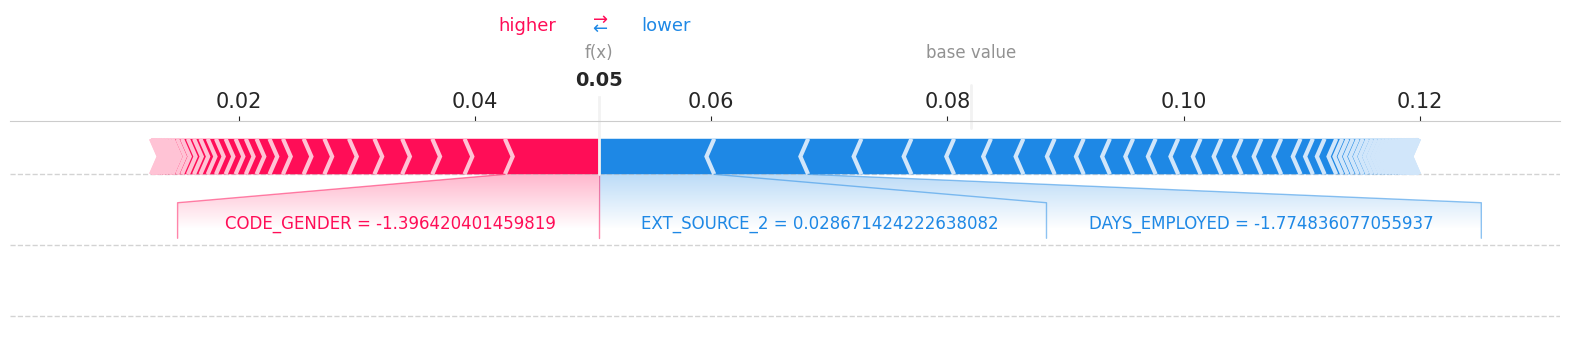

In [ ]:
import matplotlib
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], subsampled_test_data[0], feature_names=X_train.columns, matplotlib=matplotlib)

To unpack and understand the results from SHAP KernelExplainer, there are a few terms worth clarifying

  0%|          | 0/1 [00:00<?, ?it/s]

Kernel Explainer SHAP run time 18.242  seconds.  Gradient Boosting
SHAP expected value [0.91796785 0.08203215]
Model mean value [0.91829798 0.08170202]
Model prediction for test data [[0.94951477 0.05048523]]


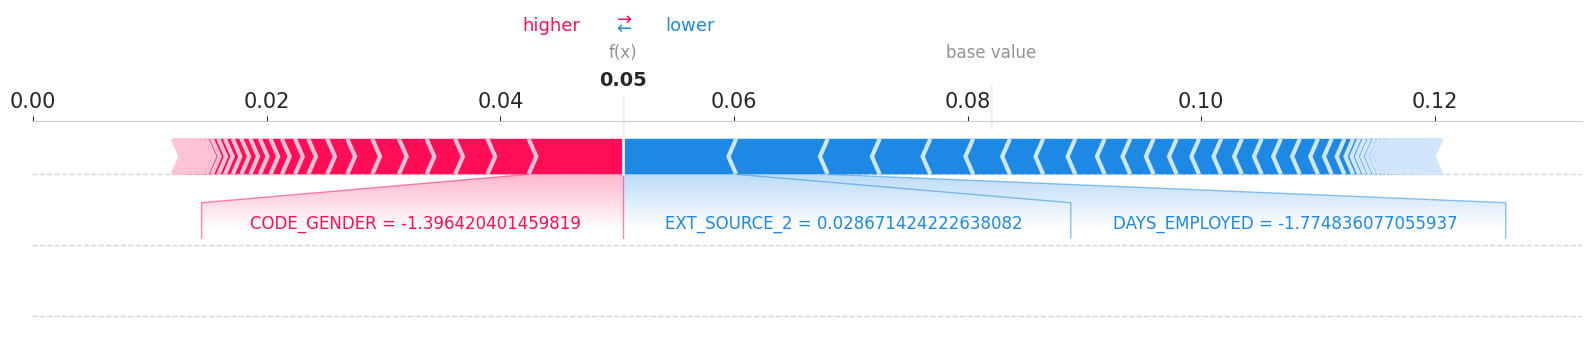

In [ ]:
current_model = trained_models[3] # Explain the Random Forest Model
clf = current_model["model"]["clf"]
scaler = current_model["model"]["scaler"]
scaled_train_data = scaler.transform(X_train)
sub_sampled_train_data = shap.sample(scaled_train_data, 600, random_state=0) # use 600 samples of train data as background data

test_data_index=10
scaled_test_data = scaler.transform(X_test)
subsampled_test_data =scaled_test_data[test_data_index].reshape(1,-1)

start_time = time.time()
explainer = shap.KernelExplainer(clf.predict_proba, sub_sampled_train_data)
shap_values = explainer.shap_values(subsampled_test_data,  l1_reg="aic")
elapsed_time = time.time() - start_time
# explain first sample from test data
print("Kernel Explainer SHAP run time", round(elapsed_time,3) , " seconds. ", current_model["name"])
print("SHAP expected value", explainer.expected_value)
print("Model mean value", clf.predict_proba(scaled_train_data).mean(axis=0))
print("Model prediction for test data", clf.predict_proba(subsampled_test_data))

pred_ind = 0
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], subsampled_test_data[0], feature_names=X_train.columns, matplotlib=matplotlib)

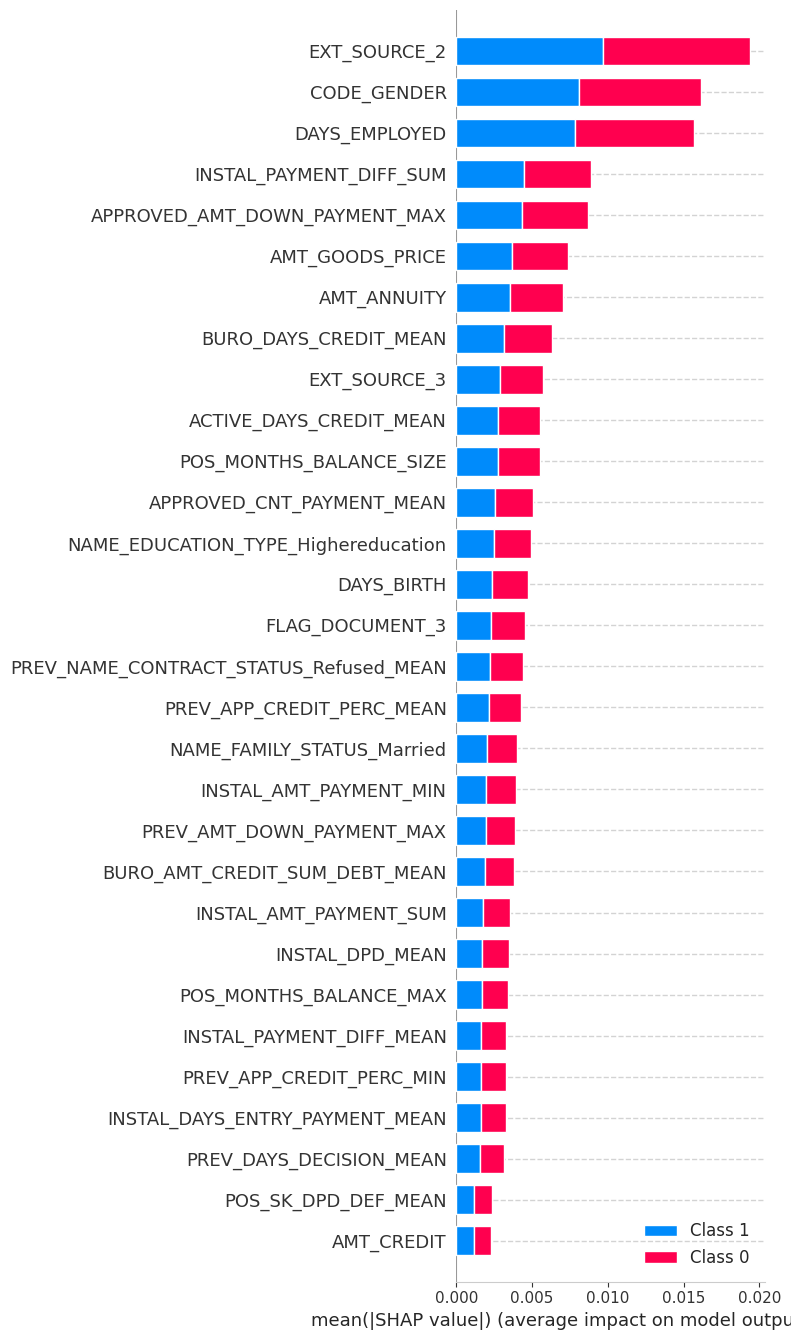

In [ ]:
shap.initjs()
shap.summary_plot(shap_values, subsampled_test_data, feature_names=X_train.columns, max_display=30)

### Explication de l'arbre
TreeExplainer sur des forêts aléatoires prend environ 0,091 seconde. Ceci est comparé aux > 12,15 secondes requises par KernelExplainer ( > 100 fois plus rapide[texte du lien](https://)

In [ ]:
current_model = trained_models[3]
clf = current_model["model"]["clf"]
scaler = current_model["model"]["scaler"]

scaled_test_data = scaler.transform(X_test)
subsampled_test_data =scaled_test_data[test_data_index].reshape(1,-1)

# explain first sample from test data
start_time = time.time()
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(subsampled_test_data)
elapsed_time = time.time() - start_time

print("Tree Explainer SHAP run time", round(elapsed_time,3) , " seconds. ", current_model["name"])
print("SHAP expected value", explainer.expected_value)
print("Model mean value", clf.predict_proba(scaled_train_data).mean(axis=0))
print("Model prediction for test data", clf.predict_proba(subsampled_test_data))
shap.initjs()
pred_ind = 0
shap.force_plot(explainer.expected_value[0], shap.Explanation(shap_values[0][1]), features=subsampled_test_data[0], feature_names=X_train.columns)
#shap.force_plot(explainer.expected_value[0], shap_values[0][1], subsampled_test_data[0], feature_names=X_train.columns)

Tree Explainer SHAP run time 0.003  seconds.  Gradient Boosting
SHAP expected value [-2.7210063]
Model mean value [0.91829798 0.08170202]
Model prediction for test data [[0.94951477 0.05048523]]


ValueError: visualize() can only display Explanation objects (or arrays of them)!

In [ ]:
print(shap_values[0][1])

0.11323852356768685


In [ ]:
print(explainer.expected_value[1])

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
import shap

def get_kernel_shap_explainer(model, background_data, train_data):
  shap_explainer = shap.KernelExplainer(model.predict_proba, background_data)
  return shap_explainer

def shap_explain(explainer, test_data):
  shap_values = explainer.shap_values(test_data, l1_reg="aic")

  return shap_values

shap_data_explainations = []
shape_explanation_time = []
feat_names = list(df_clean.columns)
data_subsample = 500
for current_model in trained_models:
  scaler = current_model["model"]["scaler"]
  scaled_test_data = scaler.transform(X_test)
  scaled_train_data = scaler.transform(X_train)
  sampled_scaled_train_data = shap.sample(scaled_train_data, data_subsample) # subsample background data to make things faster

  start_time = time.time()
  shap_explainer  = get_kernel_shap_explainer(current_model["model"]["clf"], sampled_scaled_train_data, scaled_train_data)

  # explain first sample from test data
  sampled_scaled_test_data = scaled_test_data[test_data_index].reshape(1,-1)
  shap_values = shap_explain(shap_explainer, sampled_scaled_test_data)
  elapsed_time = time.time() - start_time
  idx = np.argsort(np.abs(shap_values[1][0]))[::-1]
  ex_holder = { feat_names[idx[i]] : shap_values[1][0][idx[i]] for i in range(top_x)}


  shap_data_explainations.append(ex_holder)
  shape_explanation_time.append({"time": elapsed_time, "model": current_model["name"] })


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
def plot_lime_exp(fig, fig_index, exp_data, title):
  features =  list(exp_data.keys())[::-1]
  explanations = list(exp_data.values())[::-1]
  ax = fig.add_subplot(fig_index)
  lime_bar = ax.barh( features, explanations )
  ax.set_title(title, fontsize = 20)
  for i,bar in enumerate(lime_bar):
    bar.set_color(color_list[list(df_clean.columns).index(features[i])])
    plt.box(False)
  fig = plt.figure(figsize=(19,8))

In [ ]:
def plot_shap_exp(fig, fig_index, exp_data, title):
  features =  list(exp_data.keys())[::-1]
  explanations = list(exp_data.values())[::-1]
  ax = fig.add_subplot(fig_index)
  lime_bar = ax.barh( features, explanations )
  ax.set_title(title, fontsize = 20)
  for i,bar in enumerate(lime_bar):
    bar.set_color(color_list[list(df_clean.columns).index(features[i])])
    plt.box(False)


# Plot SHAP explanations for a given test set item
#fig = plt.figure(figsize=(19,8))
#for i, dex in enumerate(shap_data_explainations):
  #fig_index = "23" + str(i+1)
  #plot_lime_exp(fig, fig_index, shap_data_explainations[i], trained_models[i]["name"])

plt.suptitle( "Kernel SHAP Explanation for single test data instance.  Top " + str(top_x) + " Features", fontsize=20, fontweight="normal")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Plot SHAP explanation run time
shapx_df = pd.DataFrame(shape_explanation_time)
shapx_df.sort_values("time", inplace=True)
setup_plot()
shapx_df_ax = shapx_df.plot(kind="line", x="model", title="Runtime (seconds) for single instance SHAP explanation", figsize=(22,6))
shapx_df_ax.title.set_size(20)
shapx_df_ax.legend(["Run time"])
plt.box(False)


# Plot both LIME and SHAP explanation run times
m_df =  shapx_df.merge(shapx_df, on="model", suffixes=("_SHAP", "_LIME"))
m_df.head()
mx_df_ax = m_df.plot(kind="line", x="model", title="Kernel SHAP: Runtime (seconds) for single instance explanation", figsize=(22,6))
mx_df_ax.title.set_size(20)
mx_df_ax.legend(["Run time for SHAP"])
plt.box(False)

KeyError: 'time'

<Figure size 900x600 with 0 Axes>

Traiter le déséquilibre des classes avec la librairie SMOTE

In [ ]:
!pip install imbalanced-learn

In [ ]:
# check version number
import imblearn
print(imblearn.__version__)

0.10.1


Le nuage de points de l'ensemble de données montre la grande masse de points appartenant à la classe majoritaire (orange) et un petit nombre de points répartis pour la classe minoritaire (bleu). Nous pouvons constater un certain chevauchement entre les deux classes

Application de SMOTE à l'ensemble de données synthétiques, puis de synthèse et de traçage du résultat transformé sont répertoriés

Counter({0.0: 67314, 1.0: 5979})
Counter({1.0: 67314, 0.0: 67314})
[     0     38     40 ... 134625 134626 134627]
[    1     2     3 ... 73288 73290 73292]


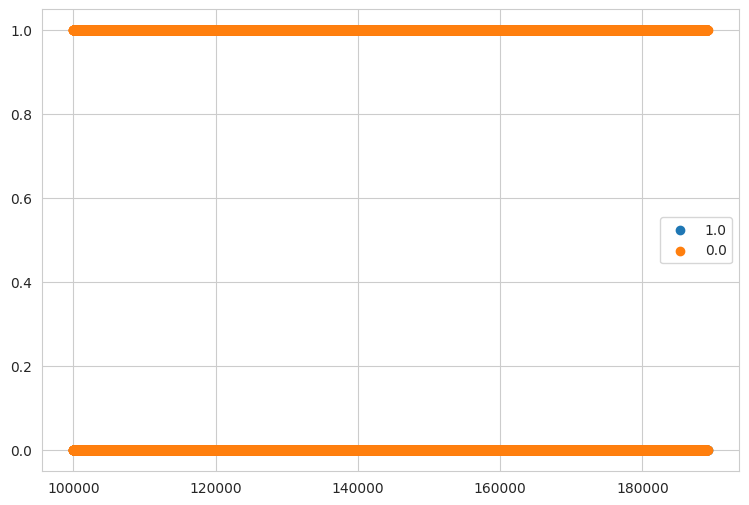

In [ ]:
# Oversample and plot imbalanced dataset with SMOTE
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from numpy import where
df_application_train = df_clean[df_clean['TARGET'].notnull()]
df_application_test = df_clean[df_clean['TARGET'].isnull()]
X = df_application_train.drop('TARGET', axis=1)
medians = X.median()  # Calculer la médiane de chaque colonne
X.replace(np.inf, medians, inplace=True)
X.replace(-np.inf, medians, inplace=True)
X = X.fillna(medians)
y = df_application_train['TARGET']
# summarize class distribution
counter = Counter(y)
print(counter)
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y == label)[0]
	print(row_ix)
	pyplot.scatter(X.iloc[row_ix, 0], X.iloc[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

<Axes: ylabel='Frequency'>

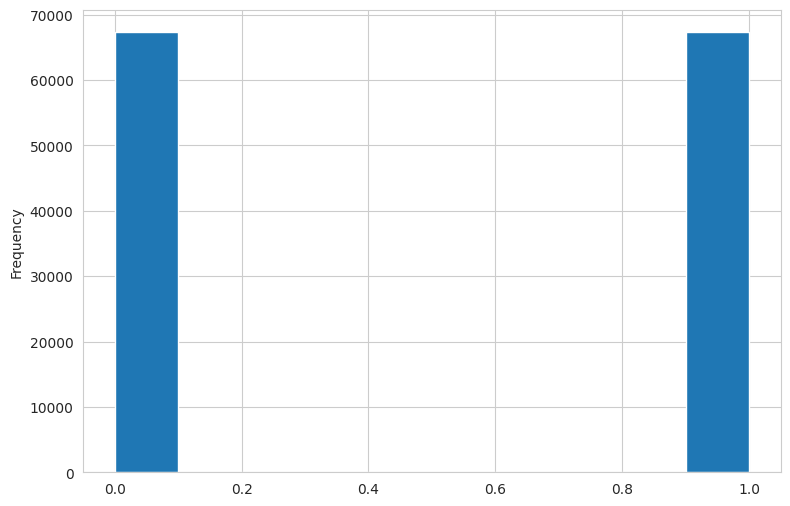

In [ ]:
y.plot.hist()

In [ ]:
# decision tree evaluated on imbalanced dataset
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
# define model
model = DecisionTreeClassifier()
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.878


In [ ]:
# grid search k value for SMOTE oversampling for imbalanced classification
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# define dataset
#X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	#n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
# values to evaluate
k_values = [1, 2, 3, 4, 5, 6, 7]
for k in k_values:
	# define pipeline
	model = DecisionTreeClassifier()
	over = SMOTE(sampling_strategy="auto", k_neighbors=k)
	under = RandomUnderSampler(sampling_strategy="auto")
	steps = [('over', over), ('under', under), ('model', model)]
	pipeline = Pipeline(steps=steps)
	# evaluate pipeline
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
	scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
	score = mean(scores)
	print('> k=%d, Mean ROC AUC: %.3f' % (k, score))

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


> k=1, Mean ROC AUC: 0.879


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


KeyboardInterrupt: 

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Assuming 'X' is your feature matrix and 'y' is your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Specify the desired ratio (e.g., 1:2)
sampling_ratio = {0: len(y_train[y_train == 0]), 1: 2 * len(y_train[y_train == 1])}

# Apply SMOTE with the specified ratio
smote = SMOTE(sampling_strategy=sampling_ratio, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train your model on the resampled data
model = RandomForestClassifier()
model.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

After over-sampling, the number of samples (107786) in class 1 will be larger than the number of samples in the majority class (class #1.0 -> 53893)


              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96     13505
         1.0       0.99      0.92      0.95     13421

    accuracy                           0.96     26926
   macro avg       0.96      0.95      0.95     26926
weighted avg       0.96      0.96      0.96     26926



Counter({0.0: 67314, 1.0: 5979})
Counter({1.0: 67314, 0.0: 67314})


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Counter({0.0: 67314, 1.0: 5979})
Counter({1.0: 67314, 0.0: 67314})
Counter({0.0: 67314, 1.0: 5979})
Counter({1.0: 67314, 0.0: 67314})
Counter({0.0: 67314, 1.0: 5979})
Counter({1.0: 67314, 0.0: 67314})


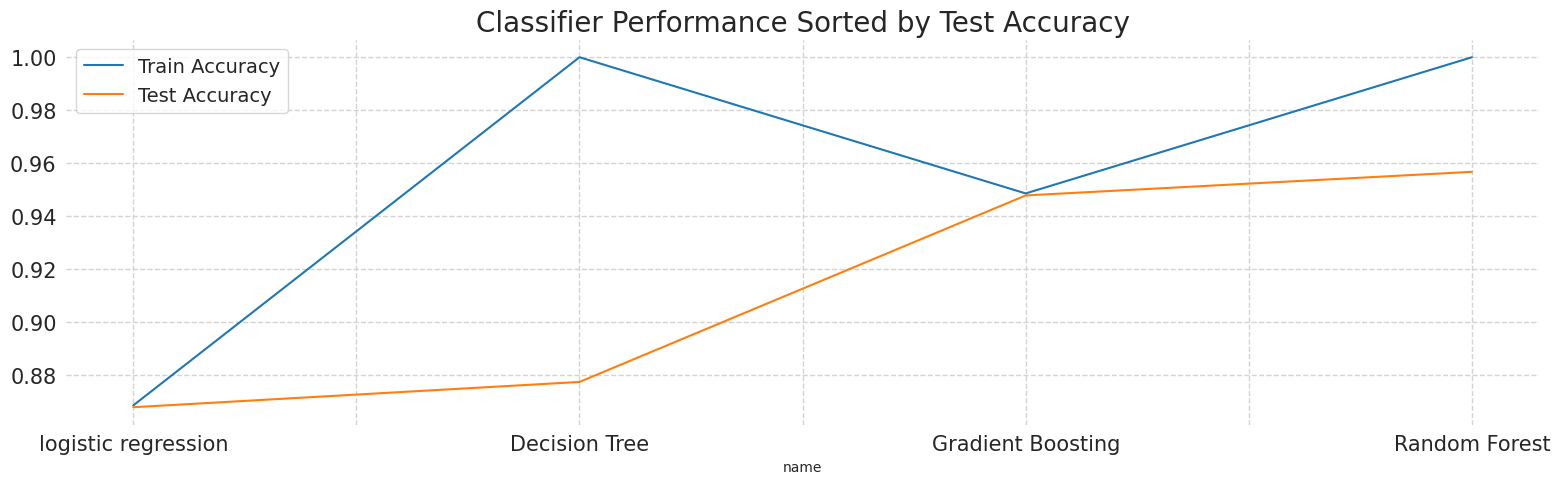

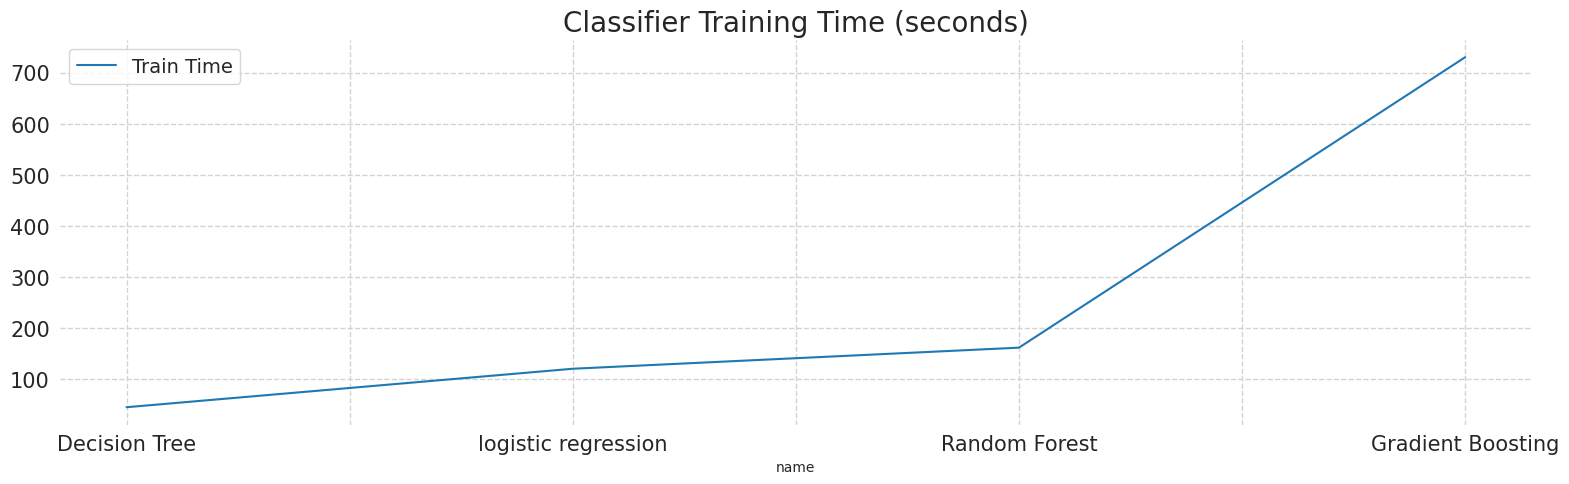

In [ ]:
#@title
import time
import matplotlib.pyplot as plt
from sklearn import ensemble, pipeline
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV

trained_models = [] #  keep track of all details for models we train
def train_model(model, data, labels):
  labels = df_clean.columns
# Diviser les données avec des valeurs cibles
  df_application_train = df_clean[df_clean['TARGET'].notnull()]
  df_application_test = df_clean[df_clean['TARGET'].isnull()]
  X = df_application_train.drop('TARGET', axis=1)
  medians = X.median()  # Calculer la médiane de chaque colonne
  X.replace(np.inf, medians, inplace=True)
  X.replace(-np.inf, medians, inplace=True)
  X = X.fillna(medians)
  y = df_application_train['TARGET']
  # summarize class distribution
  counter = Counter(y)
  print(counter)
  # transform the dataset
  oversample = SMOTE()
  X, y = oversample.fit_resample(X, y)
  # summarize the new class distribution
  counter = Counter(y)
  print(counter)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

  pipe = pipeline.Pipeline([('scaler', preprocessing.StandardScaler()),('clf', model["clf"])])
  start_time = time.time()
  pipe.fit(X_train, y_train)
  train_time = time.time() - start_time

  train_accuracy =  pipe.score(X_train, y_train)
  test_accuracy = pipe.score(X_test, y_test)
  model_details = {"name": model["name"], "train_accuracy":train_accuracy, "test_accuracy":test_accuracy, "train_time": train_time, "model": pipe}
  return model_details

models = [
          {"name": "logistic regression", "clf": LogisticRegressionCV()},
          {"name": "Decision Tree", "clf": DecisionTreeClassifier()},
          {"name": "Random Forest", "clf": RandomForestClassifier(n_estimators=100)},
          {"name": "Gradient Boosting", "clf": GradientBoostingClassifier(n_estimators=100)}]

for model in models:
  model_details = train_model(model, df_clean, labels)
  trained_models.append(model_details)


# visualize accuracy and run time
setup_plot()
model_df = pd.DataFrame(trained_models)
model_df.sort_values("test_accuracy", inplace=True)
ax = model_df[["train_accuracy","test_accuracy", "name"]].plot(kind="line", x="name", figsize=(19,5), title="Classifier Performance Sorted by Test Accuracy")
ax.legend(["Train Accuracy", "Test Accuracy"])
for p in ax.patches:
    ax.annotate( str( round(p.get_height(),3) ), (p.get_x() * 1.005, p.get_height() * 1.005))

ax.title.set_size(20)
plt.box(False)

model_df.sort_values("train_time", inplace=True)
ax= model_df[["train_time","name"]].plot(kind="line", x="name", figsize=(19,5), grid=True, title="Classifier Training Time (seconds)")
ax.title.set_size(20)
ax.legend(["Train Time"])
plt.box(False)

In [ ]:
!pip install dash

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 39.7 MB/s eta 0:00:00


In [ ]:
from dash import Dash, html, dcc, callback, Output, Input
import plotly.express as px
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/gapminder_unfiltered.csv')

app = Dash(__name__)

app.layout = html.Div([
    html.H1(children='Title of Dash App', style={'textAlign':'center'}),
    dcc.Dropdown(df.country.unique(), 'Canada', id='dropdown-selection'),
    dcc.Graph(id='graph-content')
])

@callback(
    Output('graph-content', 'figure'),
    Input('dropdown-selection', 'value')
)
def update_graph(value):
    dff = df[df.country==value]
    return px.line(dff, x='year', y='pop')

if __name__ == '__main__':
    app.run(debug=True)


<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

df_application_train = df_clean[df_clean['TARGET'].notnull()]
df_application_test = df_clean[df_clean['TARGET'].isnull()]
X = df_application_train.drop('TARGET', axis=1)
medians = X.median()  # Calculer la médiane de chaque colonne
X.replace(np.inf, medians, inplace=True)
X.replace(-np.inf, medians, inplace=True)
X = X.fillna(medians)
y = df_application_train['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialiser le modèle RandomForestClassifier
model = RandomForestClassifier()
# Entraîner le modèle
model.fit(X_train_scaled, y_train)
# Prédire les scores pour l'ensemble de test
y_pred = model.predict(X_test_scaled)


import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd

#from your_prediction_module import predict_scores  # Remplacez 'your_prediction_module' par le nom de votre module de prédiction
from sklearn.metrics import confusion_matrix, make_scorer
# Define a custom scoring function
def custom_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return 10 * fn + fp
# Create a scorer from the custom scoring function
custom_scorer = make_scorer(custom_score, greater_is_better=False)


# Initialisation de l'application Dash
app = dash.Dash(__name__)

# Mise en page du tableau de bord
app.layout = html.Div(children=[
    html.H1(children='Tableau de Bord avec Prédictions'),

    dcc.Graph(
        id='example-graph',
        figure=px.scatter(df_clean, x= df_clean.columns, y='TARGET', title='Graphique de dispersion')
    ),

    html.Label('Sélectionnez une colonne :'),
    dcc.Dropdown(
        id='dropdown-column',
        options=[
            {'label': df_clean.columns, 'value': df_clean.values},
            {'label': 'TARGET', 'value': y.values}
        ],
        value=df_clean.values
    )
])

# Définition des callbacks pour les mises à jour dynamiques
@app.callback(
    Output('example-graph', 'figure'),
    [Input('dropdown-column', 'value')]
)
def update_graph(selected_column):
    predicted_scores = custom_scorer(y_test, y_pred)

    # Mise à jour du graphique avec les scores prédits
    updated_figure = px.scatter(y_test, x=selected_column, y=predicted_scores, title=f'Prédictions en fonction de {selected_column}')
    return updated_figure

# Lancement de l'application
if __name__ == '__main__':
    app.run_server(debug=True)


/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

<IPython.core.display.Javascript object>

In [ ]:
!pip install fastapi

In [ ]:
!pip install uvicorn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.


# Déployement FastAPI

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df_application_train = df_clean[df_clean['TARGET'].notnull()]
df_application_test = df_clean[df_clean['TARGET'].isnull()]
X = df_application_train.drop('TARGET', axis=1)
medians = X.median()  # Calculer la médiane de chaque colonne
X.replace(np.inf, medians, inplace=True)
X.replace(-np.inf, medians, inplace=True)
X = X.fillna(medians)
y = df_application_train['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model hyperparameters
params = {
    "solver": "lbfgs",
    "max_iter": 1000,
    "multi_class": "auto",
    "random_state": 8888,
}

# Train the model
lr = LogisticRegression(**params)
lr.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = lr.predict(X_test_scaled)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)

print(y_pred)
print(accuracy)


[0. 0. 0. ... 0. 0. 0.]
0.9186847670373149


In [ ]:
# Sauvegarde du modèle
from joblib import dump
dump(lr, "lr.joblib")

['lr.joblib']

In [ ]:
!ls

drive  lr.joblib  sample_data


In [ ]:
!pip install typing_extensions

SMOTE

In [ ]:
# decision tree evaluated on imbalanced dataset
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
# Oversample and plot imbalanced dataset with SMOTE
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from numpy import where
df_application_train = df_clean[df_clean['TARGET'].notnull()]
df_application_test = df_clean[df_clean['TARGET'].isnull()]
X = df_application_train.drop('TARGET', axis=1)
medians = X.median()  # Calculer la médiane de chaque colonne
X.replace(np.inf, medians, inplace=True)
X.replace(-np.inf, medians, inplace=True)
X = X.fillna(medians)
y = df_application_train['TARGET']
# summarize class distribution
counter = Counter(y)
print(counter)
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)
# define model
model = DecisionTreeClassifier()
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

Counter({0.0: 67314, 1.0: 5979})
Counter({1.0: 67314, 0.0: 67314})


KeyboardInterrupt: 

In [ ]:
# decision tree evaluated on imbalanced dataset
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
# Oversample and plot imbalanced dataset with SMOTE
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from numpy import where
df_application_train = df_clean[df_clean['TARGET'].notnull()]
df_application_test = df_clean[df_clean['TARGET'].isnull()]
X = df_application_train.drop('TARGET', axis=1)
medians = X.median()  # Calculer la médiane de chaque colonne
X.replace(np.inf, medians, inplace=True)
X.replace(-np.inf, medians, inplace=True)
X = X.fillna(medians)
y = df_application_train['TARGET']
# summarize class distribution
counter = Counter(y)
print(counter)
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)

# split des donnees
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# define model
dtc_model = DecisionTreeClassifier()
# Train the model
dtc_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = dtc_model.predict(X_test_scaled)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)

print(y_pred)
print(accuracy)


Counter({0.0: 67314, 1.0: 5979})
Counter({1.0: 67314, 0.0: 67314})
[0. 1. 0. ... 0. 1. 0.]
0.8743593552699993


In [ ]:
# Sauvegarde du modèle
from joblib import dump
dump(dtc_model, "dtc_model.joblib")

['dtc_model.joblib']

In [ ]:
# decision tree evaluated on imbalanced dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
# Oversample and plot imbalanced dataset with SMOTE
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from numpy import where

df_application_train = df_clean[df_clean['TARGET'].notnull()]
df_application_test = df_clean[df_clean['TARGET'].isnull()]
X = df_application_train.drop('TARGET', axis=1)
medians = X.median()  # Calculer la médiane de chaque colonne
X.replace(np.inf, medians, inplace=True)
X.replace(-np.inf, medians, inplace=True)
X = X.fillna(medians)
y = df_application_train['TARGET']
# summarize class distribution
counter = Counter(y)
print(counter)
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)

# split des donnees
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# define model
rfc = RandomForestClassifier()
# Train the model
rfc.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = rfc.predict(X_test_scaled)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)

print(y_pred)
print(accuracy)

Counter({0.0: 67314, 1.0: 5979})
Counter({1.0: 67314, 0.0: 67314})
[0. 0. 0. ... 0. 1. 0.]
0.9565847136596598


In [ ]:
# Sauvegarde du modèle
from joblib import dump
dump(rfc, "rfc.joblib")

['rfc.joblib']

### Je code mon FastAPI

In [ ]:
# Librairies
from joblib import load
from typing import Optional
from fastapi import FastAPI
from pydantic import BaseModel

# chargement du modèle
loaded_model = load("./drive/lr.joblib")
# Création du nouvelle instance fastAPI
app = FastAPI()
# Définition d'un objet (une classe) pour réaliser des requêtes
class requet_body(BaseModel):
  df_clean.columns
# Définition du chemin du point de terminaison(API)
@app.post("/predict")
# Définition de la fonction de prédiction
def predict(data : requet_body):
  # Nouvelles données lesquelles on fait la prédiction
  new_data = X_test
  # prédiction
  class_idx = loaded_model.predict(new_data)[0]
  # Je retourne l' avis favorable ou non au client
  return {"class": df_clean.target_names[class_idx]}


ImportError: cannot import name 'Doc' from 'typing_extensions' (/usr/local/lib/python3.10/dist-packages/typing_extensions.py)

In [ ]:
!uvicorn main:app --reload

INFO:     Will watch for changes in these directories: ['/content']
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
INFO:     Started reloader process [14946] using StatReload
ERROR:    Error loading ASGI app. Could not import module "main".
INFO:     Stopping reloader process [14946]


In [ ]:
!ls

In [ ]:
from sklearn.model_selection import train_test_split
# Création du df_clean
df = pd.read_csv("./drive/MyDrive/fichierdata.csv")
feat_importance = pd.read_csv("./drive/MyDrive/feat_importance.csv")
df_importance = feat_importance.groupby(["feature"]).mean()["importance"].reset_index().sort_values("importance", ascending=False)
columns_to_drop = df_importance[df_importance["importance"]  < 72]["feature"].reset_index(drop=True)
df_clean = df.drop(columns=columns_to_drop).reset_index(drop=True)
missing_percentages = df_clean.isna().mean().sort_values(ascending=False)
columns_to_drop = missing_percentages[missing_percentages > 0.6].index
df_clean = df_clean.drop(columns=columns_to_drop)
pourcentage_nan_par_ligne = df_clean.isnull().mean(axis=1)
df_clean['Pourcentage_manquant'] = pourcentage_nan_par_ligne
df_clean = df_clean[df_clean['Pourcentage_manquant'] < 0.60].reset_index(drop=True)
df_clean.drop(columns=["index", "Pourcentage_manquant"], inplace=True)

# Split des données
df_application_train = df_clean[df_clean['TARGET'].notnull()]
df_application_test = df_clean[df_clean['TARGET'].isnull()]
X = df_application_train.drop('TARGET', axis=1)
medians = X.median()  # Calculer la médiane de chaque colonne
X.replace(np.inf, medians, inplace=True)
X.replace(-np.inf, medians, inplace=True)
X = X.fillna(medians)
y = df_application_train['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
df_clean_train = pd.concat([X, y], axis=1)


In [ ]:
# Échantillonnage aléatoire de 30% des lignes avec remplacement
sample = df_clean_train.sample(frac=0.1, replace=True).reset_index(drop=True)
sample.head()

SK_ID_CURR  CODE_GENDER  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0      188533            1             0           99000.0    123993.0   
1      126367            0             2          135000.0   1078200.0   
2      162381            0             0          180000.0    337761.0   
3      184408            0             1          112500.0    180000.0   
4      118156            1             0          157500.0    338832.0   

   AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0       6093.0         103500.0                    0.015221      -20787   
1      38331.0         900000.0                    0.008230      -11267   
2      20538.0         256500.0                    0.025164      -17807   
3       9000.0         180000.0                    0.010643      -11572   
4      20605.5         292500.0                    0.016612      -11596   

   DAYS_EMPLOYED  ...  INSTAL_AMT_INSTALMENT_SUM  INSTAL_AMT_PAYMENT_MIN  \
0        -1669.0  ...                 115026.300                 120.780   
1        -3417.0  ...                 135209.205                 124.335   
2        -1762.0  ...                 298741.725                  19.845   
3         -954.0  ...                  77314.590                7739.460   
4        -1100.0  ...                  41626.305                3437.055   

   INSTAL_AMT_PAYMENT_MAX  INSTAL_AMT_PAYMENT_MEAN  INSTAL_AMT_PAYMENT_SUM  \
0                5492.115              4205.580000              100933.920   
1               38760.660              6300.573750              126011.475   
2               24312.960              2488.951875              298674.225   
3               61835.670             25771.530000               77314.590   
4                3471.750              3468.858750               41626.305   

   INSTAL_DAYS_ENTRY_PAYMENT_MAX  INSTAL_DAYS_ENTRY_PAYMENT_MEAN  \
0                          -44.0                     -534.583333   
1                         -323.0                    -1146.500000   
2                          -14.0                    -1245.616667   
3                         -449.0                     -481.333333   
4                        -2047.0                    -2218.083333   

   INSTAL_DAYS_ENTRY_PAYMENT_SUM  INSTAL_COUNT  TARGET  
0                       -12830.0          24.0     0.0  
1                       -22930.0          20.0     0.0  
2                      -149474.0         120.0     0.0  
3                        -1444.0           3.0     0.0  
4                       -26617.0          12.0     0.0  

[5 rows x 309 columns]

In [ ]:
sample = sample.drop(columns="SK_ID_CURR")
sample.head()

CODE_GENDER  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0            1             0           99000.0    123993.0       6093.0   
1            0             2          135000.0   1078200.0      38331.0   
2            0             0          180000.0    337761.0      20538.0   
3            0             1          112500.0    180000.0       9000.0   
4            1             0          157500.0    338832.0      20605.5   

   AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0         103500.0                    0.015221      -20787        -1669.0   
1         900000.0                    0.008230      -11267        -3417.0   
2         256500.0                    0.025164      -17807        -1762.0   
3         180000.0                    0.010643      -11572         -954.0   
4         292500.0                    0.016612      -11596        -1100.0   

   DAYS_REGISTRATION  ...  INSTAL_AMT_INSTALMENT_SUM  INSTAL_AMT_PAYMENT_MIN  \
0            -3858.0  ...                 115026.300                 120.780   
1            -1118.0  ...                 135209.205                 124.335   
2            -7039.0  ...                 298741.725                  19.845   
3            -5784.0  ...                  77314.590                7739.460   
4            -1267.0  ...                  41626.305                3437.055   

   INSTAL_AMT_PAYMENT_MAX  INSTAL_AMT_PAYMENT_MEAN  INSTAL_AMT_PAYMENT_SUM  \
0                5492.115              4205.580000              100933.920   
1               38760.660              6300.573750              126011.475   
2               24312.960              2488.951875              298674.225   
3               61835.670             25771.530000               77314.590   
4                3471.750              3468.858750               41626.305   

   INSTAL_DAYS_ENTRY_PAYMENT_MAX  INSTAL_DAYS_ENTRY_PAYMENT_MEAN  \
0                          -44.0                     -534.583333   
1                         -323.0                    -1146.500000   
2                          -14.0                    -1245.616667   
3                         -449.0                     -481.333333   
4                        -2047.0                    -2218.083333   

   INSTAL_DAYS_ENTRY_PAYMENT_SUM  INSTAL_COUNT  TARGET  
0                       -12830.0          24.0     0.0  
1                       -22930.0          20.0     0.0  
2                      -149474.0         120.0     0.0  
3                        -1444.0           3.0     0.0  
4                       -26617.0          12.0     0.0  

[5 rows x 308 columns]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Fonction pour entraîner un modèle et obtenir les importances des fonctionnalités
def train_model_and_get_feature_importance(data, client_id):
    # Filtrer les données en fonction du client spécifié
    #filtered_data = data.loc[client_id]

    # Séparation des caractéristiques et de la cible
    X = data.drop('TARGET', axis=1)
    medians = X.median()
    X.replace(np.inf, medians, inplace=True)
    X.replace(-np.inf, medians, inplace=True)
    X = X.fillna(medians)
    y = data['TARGET']

    # Création du modèle
    model = RandomForestClassifier()

    # Entraînement du modèle
    model.fit(X, y)

    # Initialiser l'explorateur SHAP avec le modèle entraîné
    explainer = shap.TreeExplainer(model)

    # Calculer les valeurs SHAP pour l'ensemble des données
    shap_values = explainer.shap_values(X)

    # Obtention de l'importance globale



In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 6.9 MB/s eta 0:00:00


In [ ]:
import shap

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Fonction pour entraîner un modèle et obtenir les importances des fonctionnalités
def train_model_and_get_feature_importance(data, client_id):
    # Filtrer les données en fonction du client spécifié
    #filtered_data = data.loc[client_id]

    # Séparation des caractéristiques et de la cible
    X = data.drop('TARGET', axis=1)
    medians = X.median()
    X.replace(np.inf, medians, inplace=True)
    X.replace(-np.inf, medians, inplace=True)
    X = X.fillna(medians)
    y = data['TARGET']
    print(X.shape, y.shape)
    # Création du modèle
    model = RandomForestClassifier()

    # Entraînement du modèle
    model.fit(X, y)

    # Initialiser l'explorateur SHAP avec le modèle entraîné
    explainer = shap.TreeExplainer(model)

    # Calculer les valeurs SHAP pour l'ensemble des données
    shap_values = np.array(explainer.shap_values(X))
    print(shap_values.shape)
    # Obtention de l'importance globale

    #global_shap_df = (
       # pd.DataFrame(np.abs(shap_values)
      #  .mean(axis=0), index=X.columns, columns=['SHAP Value'])
     #   .sort_values(by='SHAP Value', ascending=False)
    #)
    shap_values_transposed = shap_values.T  # Transposer les valeurs SHAP
    global_shap_df = (
        pd.DataFrame(np.abs(shap_values_transposed).mean(axis=0), columns=['SHAP Value'], index=X.columns)
        .sort_values(by='SHAP Value', ascending=False)
    )

    print(global_shap_df)

    local_shap_values = (
        pd.DataFrame(shap_values_transposed[0], index=X.columns, columns=['SHAP Value'])
        .sort_values(by='SHAP Value', ascending=False)
    )
    print(local_shap_values)
    return local_shap_values, global_shap_df

In [ ]:
train_model_and_get_feature_importance(sample, 0)

(7329, 307) (7329,)
(2, 7329, 307)


ValueError: Shape of passed values is (7329, 2), indices imply (307, 1)

In [ ]:
def create_global_importance_graph(global_importance):
    fig = px.bar(
        global_importance,
        y=global_importance.index,
        x="Shap value",
        orientation="h",
        #text=[global_importance],
        #labels={'x': 'Importance', 'y': 'Value'},
        title='Global Feature Importance'
    )
    return fig

# Créer un graphique à barres pour afficher l'importance locale
def create_local_importance_graph(shap_values, client_id):
    fig = px.bar(
        shap_values,
        y=shap_values.index,
        x="Shap value",
        orientation="h",
        #text=['Feature ' + str(i) for i in range(len(shap_values[index]))],
        #labels={'x': 'Feature Index', 'y': 'Importance'},
        title='Local Feature Importance (Sample ' + str(client_id) + ')'
    )
    return fig